In [566]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, gridplot
from bokeh.models import CustomJS, Slider, Label, LabelSet, CustomJS, ColumnDataSource, HoverTool
from bokeh.layouts import column

import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import sys
sys.path.append('../../drifter')
from importlib import reload
import os
import utilities.cleaning as clean
import utilities.interpolation as interp

clean = reload(clean)
interp = reload(interp)
# Load Bokeh
output_notebook()

Loading BokehJS ...

In [570]:
file

'.DS_Store'

In [573]:
dataloc = '../../data/adc_dn_tracks/'
metadata = pd.read_csv(dataloc + 'DN_buoy_list_v2.csv')
metadata['filename'] = ['_'.join([x, str(y), z]) for 
                        x, y, z in zip(metadata['DN Station ID'],
                                       metadata['IMEI'],
                                       metadata['Sensor ID'])]
metadata.set_index('Sensor ID', inplace=True)
files = os.listdir(dataloc)
files = [file for file in files if file[0] != 'D']
files = [file for file in files if file.split('.')[-1] != 'xml']
files = [file for file in files if file != '.DS_Store']
buoy_data = {}
for file in files:
    buoy_data[file.replace('.csv', '').split('_')[-1]] = pd.read_csv(dataloc + file,
                                            index_col='datetime', parse_dates=True)
    
dataloc = '../data/mosaic_interpolated/'
files = os.listdir(dataloc)
files = [file for file in files if file[0] != 'D']
files = [file for file in files if file.split('.')[-1] != 'xml']
files = [file for file in files if file != '.DS_Store']
buoy_interp = {}
for file in files:
    buoy_interp[file.replace('.csv', '').split('_')[-1]] = pd.read_csv(dataloc + file,
                                            index_col='datetime', parse_dates=True)




In [572]:
# Bokeh interface goals:
# Dropdown with choice of buoy
# Dropdown with choice of variable
# Slider with date range

# Start: just getting the date range


buoys = [k for k in buoy_data.keys()]


In [655]:
# Calculate the minimum of the forward and backward differences. If a point is anomalous, both
# the forward and backward differences will register the error. For a point next to an anomalous
# point, only one or the other will be anomalously large.

for buoy in buoy_data:
    data = buoy_data[buoy]
    fwd_speed = clean.compute_speed(data.copy(), date_index=True, difference='forward')   
    bwd_speed = clean.compute_speed(data.copy(), date_index=True, difference='backward')
    speed = pd.DataFrame({'b': bwd_speed['speed'], 'f': fwd_speed['speed']}).min(axis=1)
    u = pd.DataFrame({'b': np.abs(bwd_speed['u']), 'f': np.abs(fwd_speed['u'])}).min(axis=1)
    v = pd.DataFrame({'b': np.abs(bwd_speed['v']), 'f': np.abs(fwd_speed['v'])}).min(axis=1)    
    buoy_data[buoy]['speed_bf'] = speed
    buoy_data[buoy]['x'] = fwd_speed['x']
    buoy_data[buoy]['y'] = fwd_speed['y']
    buoy_data[buoy]['u'] = u
    buoy_data[buoy]['v'] = v

In [656]:
# Calculate the number of neighboring points. Points without neighbors or with only one neighbor are 
# considered outliers and flagged for removal.
def dist_from_median(xvar, yvar, data, window):
    """Computes the distance of the point from the median of a moving window."""
    xa = data[xvar] - data[xvar].rolling(window, center=True).median()
    ya = data[yvar] - data[yvar].rolling(window, center=True).median()
    
    return np.sqrt(xa**2 + ya**2)


In [341]:
for idx, buoy in enumerate(buoys):
    data = buoy_data[buoy].copy()
    buoy_data[buoy]['speed_flag'] = clean.check_speed(data, window='1D', sigma=6, date_index=True, method='z-score')
    if buoy_data[buoy]['speed_flag'].sum() > 0:
        print(buoy, idx, buoy_data[buoy]['speed_flag'].sum())


2019P203 6 1
2019P91 7 2
2019O4 14 1
2019O3 39 1
2020P220 43 1
2020O10 44 74
2019P152 58 1
2019P102 69 1
2019P105 75 2
2019P183 88 1
2019P206 90 1
ASFS30UCB1 128 1
2019T47 141 2
2019P205 171 3
ASFS50UCB1 172 1
2019O1 189 4
2020P219 204 1
2019P103 208 2


In [305]:
# Anomaly checks: 18 buoys with 1-22 flagged points using the 6H speed flag (neighbor method).

In [630]:
%%time
def dist_from_median(xvar, yvar, data, window):
    """Computes the distance of the point from the median of a moving window."""
    xa = data[xvar] - data[xvar].rolling(window, center=True).median()
    ya = data[yvar] - data[yvar].rolling(window, center=True).median()
    
    return np.sqrt(xa**2 + ya**2)
# Window can be either based on time window or on the an integer number of neighbors.
window = 5
eps = 1

for buoy in buoy_data:
    data = buoy_data[buoy]
    data['dist_from_median_uv'] = dist_from_median('u', 'v', data, window)
    data['dist_from_median_xy'] = dist_from_median('x', 'y', data, window)

    # standardize
    # Attempting to use rolling 30-day interquartile range
    for var in ['dist_from_median_uv', 'dist_from_median_xy']:
        #X = data[var]
        #q75 = X[X>0].quantile(0.75)
        #q25 = X[X>0].quantile(0.25)
        q75 = data[var].where(data[var] > 0).rolling('30D', center=True, min_periods=15).quantile(0.75)
        q25 = data[var].where(data[var] > 0).rolling('30D', center=True, min_periods=15).quantile(0.25)
        data[var] = data[var]/(q75-q25)

    index = data.dropna().index
    X = data.loc[index, ['dist_from_median_uv', 'dist_from_median_xy']].values
    d = cdist(X, X, 'euclidean')
    data.loc[index, 'NN'] = (d < eps).sum(axis=1) # Number of data points  closer than eps        
    closest = []
    for idx in range(len(index)):
        dmin = d[idx,:]
        closest.append(dmin[dmin > 0].min())
    data.loc[index, 'closest'] = closest
    buoy_data[buoy] = data.copy()



CPU times: user 2min 41s, sys: 38.3 s, total: 3min 19s
Wall time: 3min 26s


In [632]:
saveloc = '../data/mosaic_interpolated/'

In [638]:
begin = '2019-10-15 00:00'
end = '2022-01-01 00:00'
max_dt = 2
margin = pd.to_timedelta('6H')
for buoy in buoy_data:
    data = buoy_data[buoy]
    sensorweb_id = buoy
    check_dup = clean.flag_duplicates(data, date_index=True)
    check_dates = clean.check_dates(data, date_index=True)
    
    data = data.where(~(check_dup | check_dates)).dropna()
    if len(data.loc[slice(begin, end)]) > 30*24:
        data['speed_flag'] = (data.dist_from_median_uv > 50) | (data.dist_from_median_xy > 50)
        data = data.where(~data.speed_flag).dropna()        
        
        if len(data.loc[slice(begin, end)]) > 30*24:
            dt = pd.to_timedelta(np.diff(data.index)).median().seconds/3600

            if np.round(dt,1) <= max_dt:
                data_interp = interp.interpolate_buoy_track(
                    data.loc[slice(pd.to_datetime(begin)-margin,
                                   pd.to_datetime(end)+margin)],
                    xvar='longitude', yvar='latitude', freq='1H',
                    maxgap_minutes=240)

                buoy_data[sensorweb_id] = clean.compute_speed(
                    data_interp, date_index=True, rotate_uv=True, difference='centered').loc[slice(begin, end)]
            else:
                print(sensorweb_id, dt, 'Frequency too low')
        else:
            print(sensorweb_id, 'Insufficient data after speed check: ', len(data))
    else:
        print(sensorweb_id, 'Insufficient data after dup/date checks: ', len(data))

for buoy in buoy_data:
    buoy_data[buoy].to_csv(saveloc + metadata.loc[buoy, 'filename'] + '.csv')

2020P215 3.0 Frequency too low
2019S95 Insufficient data after dup/date checks:  66
2019P153 Insufficient data after dup/date checks:  442
2019P161 Insufficient data after dup/date checks:  579
2019I2 Insufficient data after dup/date checks:  678
2020P214 3.0 Frequency too low
2020P223 Insufficient data after dup/date checks:  381
2019F1 3.0 Frequency too low
2020S109 Insufficient data after dup/date checks:  153
2020P211 3.0 Frequency too low
2020P212 Insufficient data after dup/date checks:  0
2020T60 Insufficient data after dup/date checks:  91
2019S90 Insufficient data after dup/date checks:  340
2019I3 4.000277777777778 Frequency too low
2019T71 Insufficient data after dup/date checks:  297
2019I1 3.999722222222222 Frequency too low
2019P22 3.0 Frequency too low
2019T47 Insufficient data after dup/date checks:  420
2020P210 3.0 Frequency too low
2019P145 Insufficient data after dup/date checks:  157
2019P135 Insufficient data after dup/date checks:  408
2019S80 Insufficient data a

(array([239.,  55.,  23.,   7.,   2.,   4.,   0.,   2.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19]),
 <BarContainer object of 18 artists>)

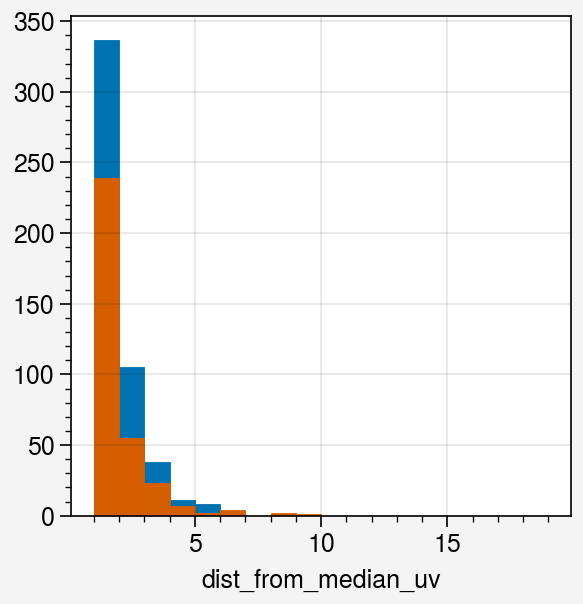

In [598]:
fig, ax = pplt.subplots()
ax.hist(data['dist_from_median_uv'], bins=np.arange(1, 20))
ax.hist(data['dist_from_median_xy'], bins=np.arange(1, 20))

## Outlier detection
I examine position and velocity anomalies using centered windows of 5 observations, so that for a quantity $X$, the anomaly is given by
$$ X_{a} = X_{i} - \mbox{median}(X_{i-2}, \cdots, X_{i+2}).$$
For velocity, an additional consideration is necessary. Centered differences give the lowest error assuming accurate position measurements, however an erroneous position measurement at index $i$ results in errors in velocity at positions $i-1$ and $i+1$. For anomaly detection, I instead calculate both the forward and the backward difference estimates of velocity
$$ UF = (X_{i+1} - X_{i}) / (t_{i+1} - t_{i}) $$
$$ UB = (X_{i} - X_{i-1}) / (t_{i} - t_{i-1}) $$
When there is an error in position at index $i$, then both $U_F$ and $U_B$ will be anomalous. I then define
$$U = \min(|UF|, |UB|)$$

The position and velocity anomalies are then computed for both the northward and eastward components, and the components are added in quadrature. 

Before using these time series to identify outliers, they need to be appropriately scaled. Seasonality in sea ice and differences in sea ice concentration along the drift track mean that the variability of the true position changes through the year. Using an interquartile range (instead of standard deviation) for scaling is coming practice for data containing outliers. Here, in some cases, the standard interquartile range is 0. I calculate instead the interquartile range over all nonzero values. I address the seasonality by computing the interquartile range on a moving 30-day centered window. The scaling factor is indicated as $S_{X}$.

$$XA = \sqrt{x_{a}^2 + y_{a}^2}/S_{XA}, UA = \sqrt{u_{a}^2 + v_{a}^2}/S_{UA}$$


Next, the Euclidean distance between points (XA_{i}, UA_{i}) and (XA_{j}, UA_{j}) is calculated for all index pairs $i, j$. The number of neighbors is calculated as the number of points that are within $\epsilon$ of each point. The parameter $\epsilon$ is tunable, as is the window size for the number of observations to calculate anomalies from. I use $\epsilon=1$ for now.

In [ ]:
import proplot as pplt
fig, ax = pplt.subplots()
ax.scatter(data.dist_from_median_uv, data.dist_from_median_xy, c=data.NN, cmap='spectral', vmin=0, vmax=10, colorbar='r')
#ax.format(xlim=(0,20), ylim=(0,20))

In [538]:
from scipy.spatial.distance import cdist
import proplot as pplt
data.columns

Index(['latitude', 'longitude', 'speed_flag', 'speed_bf', 'x', 'y', 'u', 'v',
       'dist_from_median_uv', 'dist_from_median_xy', 'NN', 'y_anom', 'x_anom'],
      dtype='object')

In [529]:
nn = data.loc[index, 'NN']
len(nn[nn == 1])

15

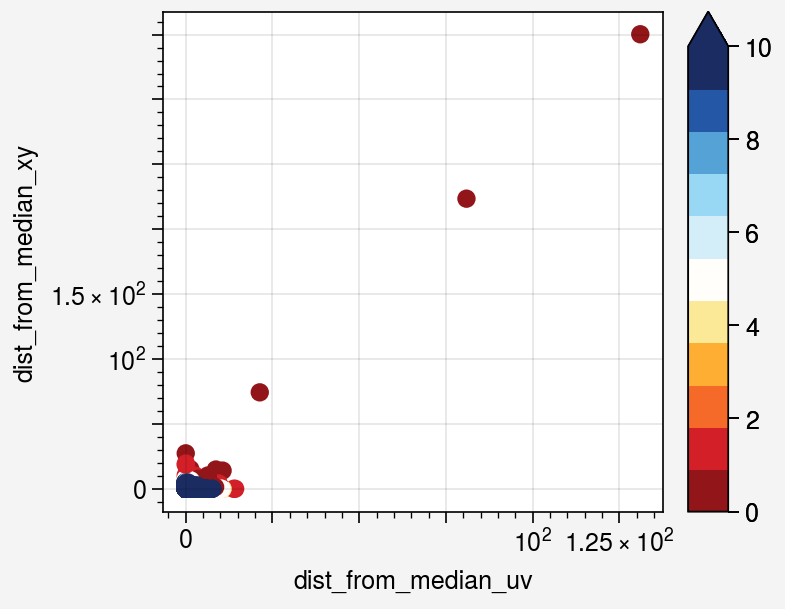

In [599]:
idx = 7
data = buoy_data[buoys[idx]]
index = data.dropna().index
fig, ax = pplt.subplots()
ax.scatter(data.loc[index].dist_from_median_uv, data.loc[index].dist_from_median_xy, c=data.loc[index, 'NN']-1,
           cmap='coldhot_r', vmin=0, vmax=10, N=11, colorbar='r', extend='max')
ax.format(xformatter='log', yformatter='log')

In [613]:
'a'.ljust(3)

'a  '

In [576]:
data['y_anom'] = data['y'] - data['y'].rolling(5, center=True).median()
data['x_anom'] = data['x'] - data['x'].rolling(5, center=True).median()

In [622]:
print('Idx', 'ID'.rjust(10), 'XA'.rjust(6), 'UA'.rjust(6))
for idx, buoy in enumerate(buoy_data):
    print(str(idx).rjust(3), buoy.rjust(10), str(np.round(buoy_data[buoy]['dist_from_median_xy'].max(),1)).rjust(6),
          str(np.round(buoy_data[buoy]['dist_from_median_uv'].max(),1)).rjust(6))

Idx         ID     XA     UA
  0     2019R9  109.2  172.9
  1   2019P142  121.6   98.1
  2    2019T66   12.2   19.7
  3   2020P164    9.7    8.5
  4     2019R8    8.4   17.8
  5   2020P170   10.2    9.2
  6   2019P203  226.1  327.5
  7    2019P91  350.2  131.0
  8   2020P176    8.5    9.0
  9   2019P151   11.6    9.2
 10   2020P171  127.2  118.5
 11 ASFS50UCB4    3.6   98.5
 12   2020P162   14.7    8.4
 13   2020P233    9.8    9.7
 14     2019O4  231.7   46.6
 15   2019P119  129.5  669.3
 16    2020S97   13.9    7.9
 17    2019T67    7.8   11.5
 18   2019P143   14.9   18.6
 19    2019S87   11.7   10.8
 20   2019P137   12.5   15.1
 21 ASFS30UCB5   11.3  100.4
 22   2020P163    9.5    9.7
 23     2019O7   16.1   13.6
 24    2020T84    8.0   11.4
 25   2020P178   15.0   43.1
 26 ASFS30UCB4    5.1    6.8
 27   2020P174    9.9   12.5
 28    2020T81    8.1   17.4
 29   2020P215    4.4    7.7
 30    2019S95    2.2    2.5
 31    2020R10   14.1    8.1
 32   2019P112  187.6  845.3
 33    2019S94

In [650]:
# Rule of thumb: values less than 20 are probably fine, values over 100 are very likely not fine
idx = 1
data = buoy_data[buoys[idx]]
index = data.dropna().index


from bokeh.layouts import gridplot
source = ColumnDataSource(data=data)
source_anom = ColumnDataSource(data=data.loc[data.NN == 1])
hover = HoverTool(tooltips=[('date', '@datetime{%Y-%m-%d %H:%M}'),
                            ],
          formatters={'@datetime': 'datetime'})


p0 = figure(x_axis_type="datetime", title=buoys[idx], plot_height=200, plot_width=800)
p0.add_tools(hover)
p0.xgrid.grid_line_color=None
p0.ygrid.grid_line_alpha=0.5
p0.xaxis.axis_label = 'Time'
p0.yaxis.axis_label = 'y'
yvars=['y']
for yvar, color in zip(yvars, ['darkblue', 'gray']):
    p0.circle('datetime', yvar, source=source, size=2, color=color)
    p0.line('datetime', yvar, source=source, line_width=1, color=color)


for yvar, color in zip(yvars, ['red', 'red']):
    p0.circle('datetime', yvar, source=source_anom, size=5, color=color)


p1 = figure(x_axis_type="datetime", x_range=p0.x_range, title=buoys[idx], plot_height=200, plot_width=800)
p1.add_tools(hover)
p1.xgrid.grid_line_color=None
p1.ygrid.grid_line_alpha=0.5
p1.xaxis.axis_label = 'Time'
p1.yaxis.axis_label = 'XA'
yvars=['dist_from_median_xy']
for yvar, color in zip(yvars, ['darkblue', 'gray']):
    p1.circle('datetime', yvar, source=source, size=2, color=color)
    p1.line('datetime', yvar, source=source, line_width=1, color=color)

for yvar, color in zip(yvars, ['red', 'red']):
    p1.circle('datetime', yvar, source=source_anom, size=5, color=color)

p2 = figure(x_axis_type="datetime", title=buoys[idx], x_range=p0.x_range, plot_height=200, plot_width=800)
p2.add_tools(hover)
p2.xgrid.grid_line_color=None
p2.ygrid.grid_line_alpha=0.5
p2.xaxis.axis_label = 'Time'
p2.yaxis.axis_label = 'UA'
yvars=['dist_from_median_uv']

for yvar, color in zip(yvars, ['darkblue', 'gray']):
    p2.circle('datetime', yvar, source=source, size=2, color=color)
    p2.line('datetime', yvar, source=source, line_width=1, color=color)

for yvar, color in zip(yvars, ['red', 'red']):
    p2.circle('datetime', yvar, source=source_anom, size=5, color=color)


p = gridplot([[p0], [p1], [p2]])
show(p)

AttributeError: 'DataFrame' object has no attribute 'NN'

In [279]:
outliers = {}
outliers['2019P112'] = ['2020-03-24 06:00:00', '2020-04-01 21:00:00', '2020-04-01 22:00:00',
                        '2020-04-17 21:00:00', '2020-08-31 00:00:00', '2020-08-31 01:00:00',
                        '2020-09-11 00:00:00', '2020-09-11 01:00:00']

# Checking the interpolated data

In [663]:
del buoys_interp
files = [f for f in os.listdir('../data/mosaic_interpolated/') if f != '.DS_Store']
buoys_interp = {f.split('.')[0].split('_')[-1]: pd.read_csv('../data/mosaic_interpolated/' + f,
                                                           index_col=0, parse_dates=True) for f in files}

In [664]:
dataloc = '../../data/annotated_adc_dn_tracks/'
metadata = pd.read_csv('../../data/adc_dn_tracks/' + 'DN_buoy_list_v2.csv')
metadata['filename'] = ['_'.join([x, str(y), z]) for 
                        x, y, z in zip(metadata['DN Station ID'],
                                       metadata['IMEI'],
                                       metadata['Sensor ID'])]
metadata.set_index('Sensor ID', inplace=True)
#dataloc = '../data/mosaic_interpolated/'
files = os.listdir(dataloc)
files = [file for file in files if file[0] != 'D']
files = [file for file in files if file.split('.')[-1] != 'xml']
buoy_data = {}
for file in files:
    buoy_data[file.replace('.csv', '').split('_')[-1]] = pd.read_csv(dataloc + file,
                                            index_col='datetime', parse_dates=True)

for buoy in buoy_data:
    buoy_data[buoy] = clean.compute_speed(buoy_data[buoy], date_index=True, rotate_uv=True, difference='centered')  
    buoy_data[buoy]['flag_dup'] = clean.flag_duplicates(buoy_data[buoy], date_index=True)
    buoy_data[buoy]['flag_date'] = clean.check_dates(buoy_data[buoy], date_index=True)



In [665]:
for idx, buoy in enumerate(buoys_interp):
    if buoy == '2019P151':
        break
print(idx)

9


In [666]:
bad_data = {'2019P142': ['2020-04-04 14:30:00', '2020-05-25 01:00:00', '2020-07-23 00:59:59'], #1
            '2019R9': ['2020-05-17 01:02:20', '2020-04-23 11:01:09', '2020-05-25 16:02:24'], #0
            '2020P171': ['2020-12-13 00:04:00', '2021-01-08 20:04:01','2021-01-08 16:04:02'], #10\
            '2019P119': ['2020-02-24 04:56:04', '2020-02-25 04:56:04'],
            '2020P178': ['2021-01-21 13:00:28'],
            '2019O5': ['2019-10-27 07:30:00', '2019-10-30 07:20:00', #205: first is subtle
                       '2019-10-31 15:40:00', '2019-10-31 15:50:00',
                       '2019-11-01 07:10:00', '2019-12-17 00:50:00',
                       '2019-12-17 01:00:00', '2020-01-09 22:50:00',
                       '2020-01-09 23:00:00', '2020-01-09 23:10:00',
                       '2020-01-18 22:40:00', '2020-02-01 22:10:00',
                       '2020-02-13 19:50:00', '2020-02-13 20:01:00',
                       '2020-04-24 15:00:00', '2020-04-24 15:10:00',
                       '2020-05-20 00:39:59', '2020-05-28 06:50:01',
                       '2020-06-10 23:09:59', '2020-06-21 03:59:59',
                       '2020-06-28 07:30:00']
           } 

In [667]:
for idx, buoy in enumerate(buoys):
    if buoy == '2019P137':
        print(idx)

20


In [668]:
# Rule of thumb: values less than 20 are probably fine, values over 100 are very likely not fine
buoys = [b for b in buoys_interp]
idx = 20

#date = pd.to_datetime(bad_data[buoys[idx]][1])
date = pd.to_datetime('2019-10-30')
margin = pd.to_timedelta('148H')
timeslice = slice(date - margin, date + margin)

data = buoy_data[buoys[idx]].loc[timeslice]
index = data.dropna().index

data_interp = buoys_interp[buoys[idx]].loc[timeslice]
index_interp = data_interp.dropna().index


source = ColumnDataSource(data=data)
source_interp = ColumnDataSource(data=data_interp)
#source_anom = ColumnDataSource(data=data.loc[data.NN == 1])
hover = HoverTool(tooltips=[('date', '@datetime{%Y-%m-%d %H:%M}'),
                            ],
          formatters={'@datetime': 'datetime'})


p0 = figure(x_axis_type="datetime", title=buoys[idx], plot_height=200, plot_width=800)
p0.add_tools(hover)
p0.xgrid.grid_line_color=None
p0.ygrid.grid_line_alpha=0.5
p0.xaxis.axis_label = 'Time'
p0.yaxis.axis_label = 'Y'
plotvar = 'y'
for s, color, size in zip([source, source_interp], ['darkblue', 'orange'], [8, 4]):

    p0.circle('datetime', plotvar, source=s, size=size, color=color)
    p0.line('datetime', plotvar, source=s, line_width=1, color=color)

p1 = figure(x_axis_type="datetime", x_range=p0.x_range, title=buoys[idx], plot_height=200, plot_width=800)
p1.add_tools(hover)
p1.xgrid.grid_line_color=None
p1.ygrid.grid_line_alpha=0.5
p1.xaxis.axis_label = 'Time'
p1.yaxis.axis_label = 'X'
plotvar='x'
for s, color, size in zip([source, source_interp], ['darkblue', 'orange'], [8, 4]):
    p1.circle('datetime', plotvar, source=s, size=size, color=color)
    p1.line('datetime', plotvar, source=s, line_width=1, color=color)

p2 = figure(x_axis_type="datetime", title=buoys[idx], x_range=p0.x_range, plot_height=200, plot_width=800)
p2.add_tools(hover)
p2.xgrid.grid_line_color=None
p2.ygrid.grid_line_alpha=0.5
p2.xaxis.axis_label = 'Time'
p2.yaxis.axis_label = 'Speed'
plotvar = 'u'
for s, color, size in zip([source, source_interp], ['darkblue', 'orange'], [8, 4]):

    p2.circle('datetime', plotvar, source=s, size=size, color=color)
    p2.line('datetime', plotvar, source=s, line_width=1, color=color)



p = gridplot([[p0], [p1], [p2]])
show(p)

Some points with high max u persist.

2019O4 0.40193526142012803
2019P119 3.081849114753823
2019P112 3.1767158872285752
2019P105 2.058467877502603
2019P114 0.543383204004461
2019P113 3.0227984516982676


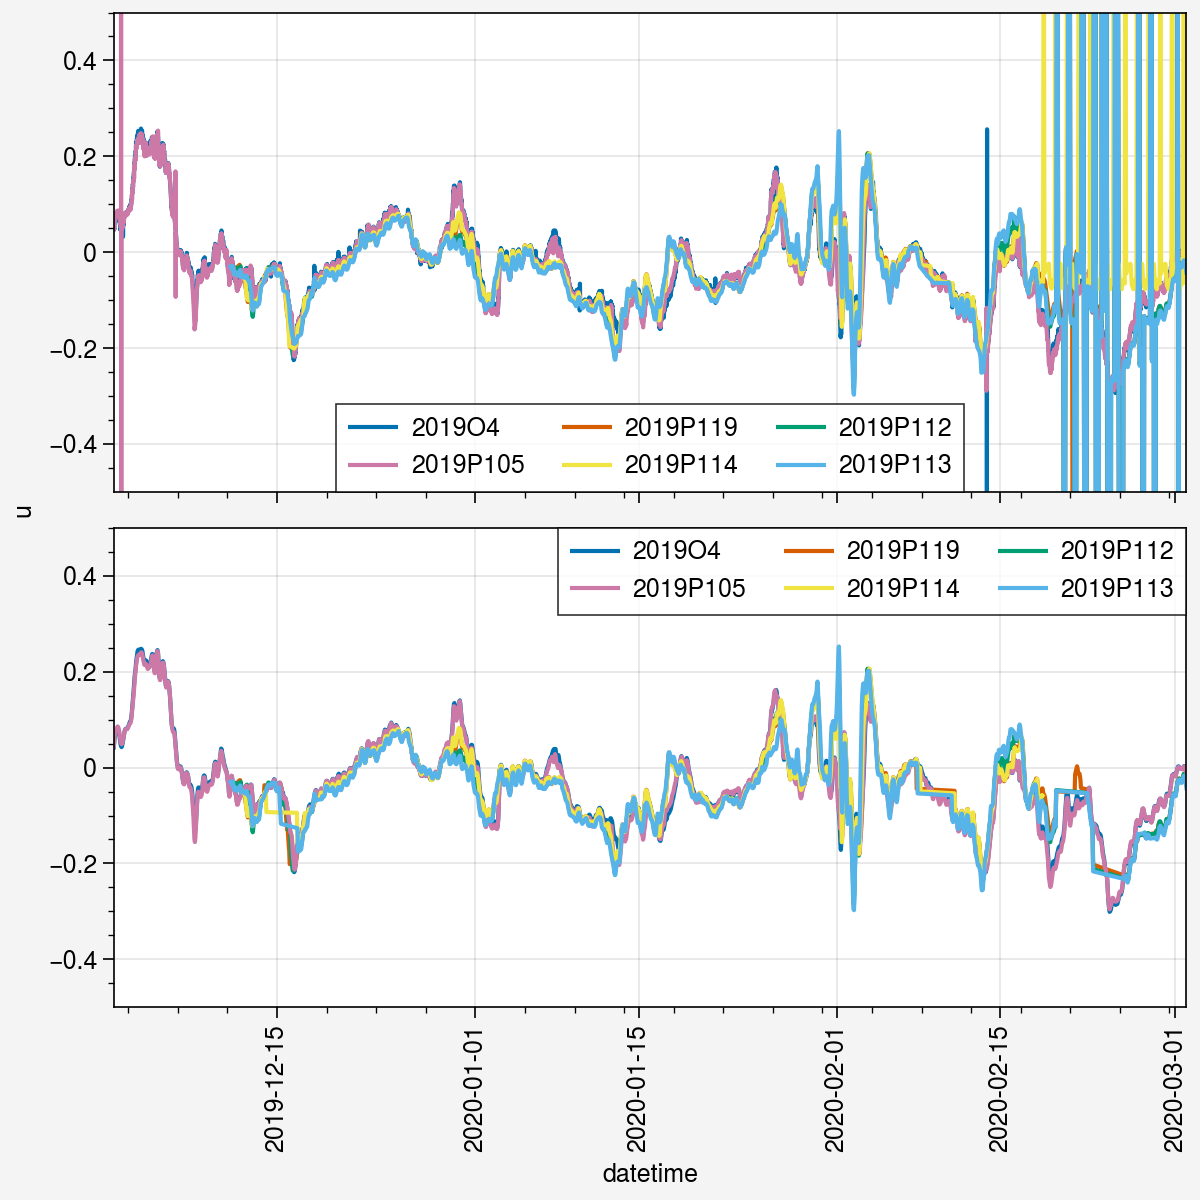

In [672]:
timeslice = slice('2019-12-01', '2020-03-01')
fig, axs = pplt.subplots(width=6, height=6, nrows=2)
h, l = [], []

for buoy in buoys_interp:
    if buoy not in skip_buoys:
        if np.any(np.abs(buoy_data[buoy].loc[timeslice]['u']) > 0.5):
            print(buoy,  buoy_data[buoy]['u'].max())
            h.append(axs[0].plot(buoy_data[buoy].loc[timeslice]['u'], label=buoy))
            l.append(buoy)
            axs[1].plot(buoys_interp[buoy].loc[timeslice]['u'], label=buoy)
#    axs[0].plot(buoy_data[buoy].loc[timeslice]['u'])
#    axs[1].plot(buoy_interp[buoy].loc[timeslice]['u'])    
axs[0].legend(h, l)
axs[1].legend()
axs.format(ylim=(-0.5, 0.5))

In [648]:
# Something is weird with 2019P22
buoy_interp['2019P22']

latitude  longitude  speed_bf              x  \
datetime                                                            
2019-10-11 00:00:00   84.9926  134.44620  0.145171 -399149.040072   
2019-10-11 03:00:00   84.9794  134.50121  0.145171 -399823.447374   
2019-10-11 06:00:00   84.9696  134.38220  0.147977 -401420.216602   
2019-10-11 09:00:00   84.9552  134.47060  0.122799 -401960.180994   
2019-10-11 12:00:00   84.9434  134.48680  0.068342 -402787.876696   
...                       ...        ...       ...            ...   
2020-05-12 12:00:00   84.7936   11.16900  0.171471 -112601.310520   
2020-05-12 15:00:00   84.7902   10.99040  0.171471 -110895.377375   
2020-05-12 18:00:00   84.7848   10.80780  0.180572 -109187.972025   
2020-05-12 21:00:00   84.7768   10.59020  0.220957 -107179.013752   
2020-05-13 00:00:00   84.7624   10.27660  0.331240 -104326.449290   

                                 y         u         v  dist_from_median_uv  \
datetime                                                                      
2019-10-11 00:00:00 -391506.614375  0.062445  0.131055                  NaN   
2019-10-11 03:00:00 -392922.005469  0.062445  0.006159                  NaN   
2019-10-11 06:00:00 -392855.492370  0.049997  0.006159             2.561687   
2019-10-11 09:00:00 -394599.936819  0.049997  0.095948             1.334216   
2019-10-11 12:00:00 -395636.177455  0.019697  0.065442             0.000000   
...                            ...       ...       ...                  ...   
2020-05-12 12:00:00  570297.441635  0.157957  0.003374             0.182867   
2020-05-12 15:00:00  571018.044893  0.157957  0.066723             0.015489   
2020-05-12 18:00:00  571960.351330  0.158093  0.087251             0.000000   
2020-05-12 21:00:00  573248.251087  0.186015  0.119250                  NaN   
2020-05-13 00:00:00  575407.100520  0.264126  0.199893                  NaN   

                     dist_from_median_xy      NN   closest  
datetime                                                    
2019-10-11 00:00:00                  NaN     NaN       NaN  
2019-10-11 03:00:00                  NaN     NaN       NaN  
2019-10-11 06:00:00             0.201622   152.0  0.201724  
2019-10-11 09:00:00             0.000000   712.0  0.000068  
2019-10-11 12:00:00             0.360140  1177.0  0.002069  
...                                  ...     ...       ...  
2020-05-12 12:00:00             0.519597  1249.0  0.025388  
2020-05-12 15:00:00             0.000000  1183.0  0.000744  
2020-05-12 18:00:00             0.000000  1175.0  0.003991  
2020-05-12 21:00:00                  NaN     NaN       NaN  
2020-05-13 00:00:00                  NaN     NaN       NaN  

[1720 rows x 11 columns]

In [672]:
# Q: why is so much getting dropped from the interpolation?
# Check: flagged for date, duplicates, speed
data_comp = pd.read_csv("../../data/" + metadata.loc['2020P171', 'filename'] + '.csv', index_col=0, parse_dates=True)

<AxesSubplot:xlabel='datetime'>

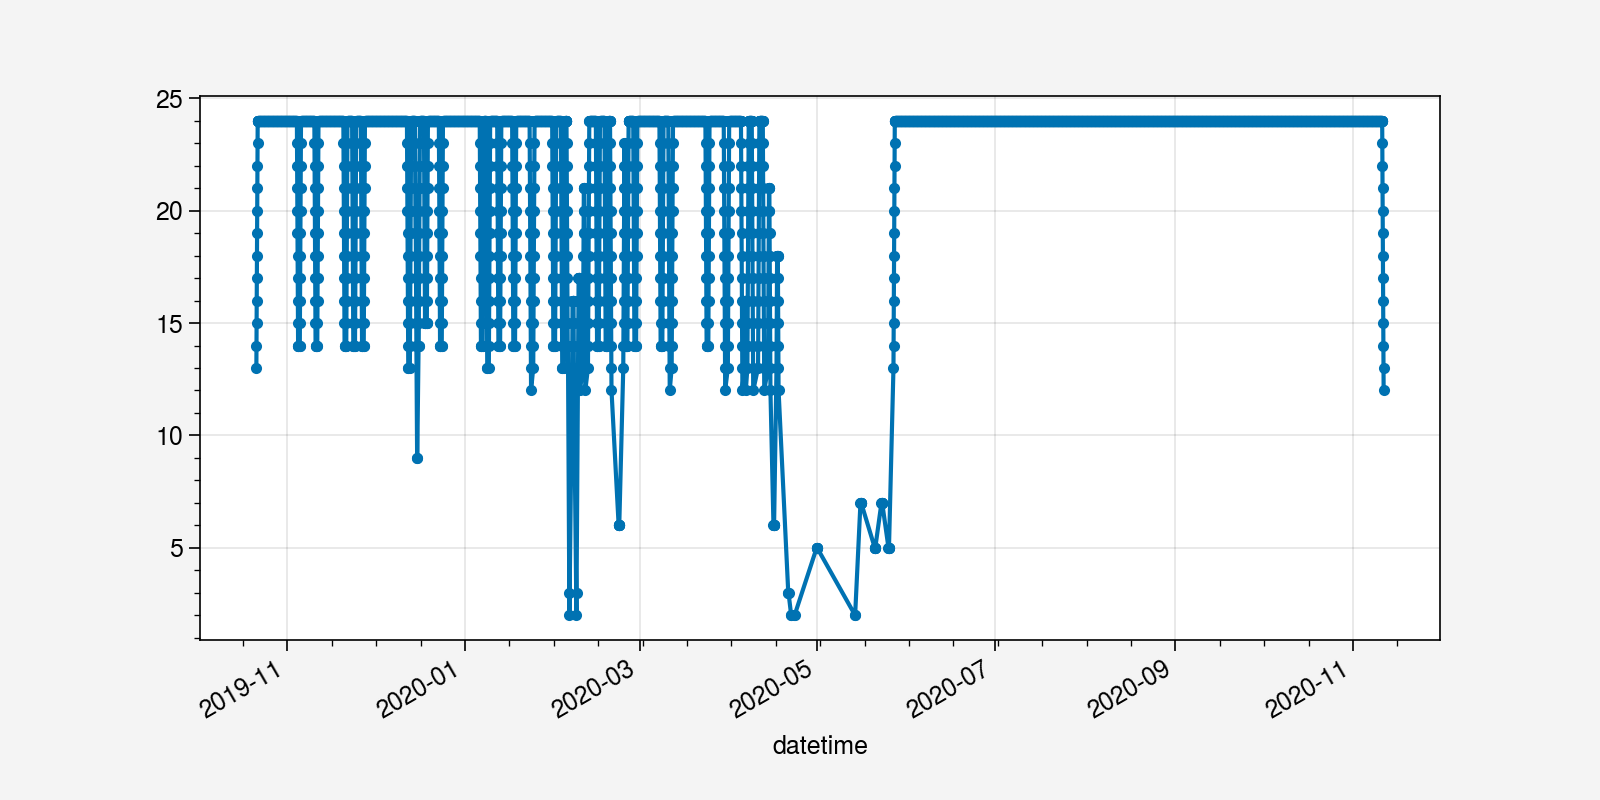

In [726]:
data_interp.rolling(window='1D', center=True).count()['longitude'].plot(marker='.', figsize=(8,4))

In [206]:
margin = pd.to_timedelta('12H')
buoys = [b for b in buoys_interp]
buoy_idx = 0
print(buoys[buoy_idx])
data = buoy_data[buoys[buoy_idx]]
index = data.dropna().index

data_interp = buoys_interp[buoys[buoy_idx]]
index_interp = data_interp.dropna().index



2019R9


In [207]:
flag_idx = []
flags = data.x.isnull()
keep_looking = True
num_flagged = flags.sum()
while keep_looking:
    check_uv = data.loc[~flags].dist_from_median_uv.std()
    check_xy = data.loc[~flags].dist_from_median_xy.std()
    check_dist = data.loc[~flags].closest.std()
    flags = (data.dist_from_median_uv > 6*check_uv) & (data.dist_from_median_xy > 6*check_xy)
    flags = flags & (data.closest > 6*check_dist)
    if num_flagged == flags.sum():
        keep_looking = False
    else:
        num_flagged = flags.sum()

In [208]:
data.loc[flags]

latitude  longitude  speed_bf              x  \
datetime                                                            
2019-11-16 18:01:19  86.07008  123.05180  0.355825 -367838.878743   
2019-11-16 19:01:24  86.06439  123.19693  0.335806 -367762.901900   
2019-11-17 12:01:21  85.92500  123.55485  0.278671 -379218.544889   
2020-03-04 18:01:45  88.11211   33.16268  0.029194 -115341.844683   
2020-04-23 11:01:09  84.08370   16.63491  1.182347 -189082.192326   
2020-05-17 01:02:20  83.45963    9.49150  0.071172 -120393.017035   
2020-05-25 16:02:24  83.39612    9.14898  0.021902 -117211.988242   
2020-05-26 11:05:05  83.44093    9.19487  0.063280 -116996.524686   

                                 y         u         v  dist_from_median_uv  \
datetime                                                                      
2019-11-16 18:01:19 -239350.443695  0.056145 -0.364423             8.368474   
2019-11-16 19:01:24 -240629.157095 -0.024303 -0.341813             8.366714   
2019-11-17 12:01:21 -251521.682553 -0.286860  0.016529            10.874625   
2020-03-04 18:01:45  176511.638459 -0.029827  0.002728             8.682905   
2020-04-23 11:01:09  632854.943701  0.005498  0.035934           171.563272   
2020-05-17 01:02:20  720096.543376 -0.000114  0.006874             9.268886   
2020-05-25 16:02:24  727794.393333 -0.006408 -0.070355             7.356731   
2020-05-26 11:05:05  722768.386804 -0.002393 -0.031603             7.437276   

                     dist_from_median_xy   NN     closest     speed  \
datetime                                                              
2019-11-16 18:01:19             6.493840  1.0    2.145043  0.368722   
2019-11-16 19:01:24             9.290201  2.0    0.929648  0.342676   
2019-11-17 12:01:21             5.249423  1.0    2.773994  0.287336   
2020-03-04 18:01:45             3.549011  1.0    1.341273  0.029951   
2020-04-23 11:01:09           109.249415  1.0  189.863392  0.036352   
2020-05-17 01:02:20            10.716985  1.0    1.688083  0.006875   
2020-05-25 16:02:24             3.348319  1.0    1.341273  0.070647   
2020-05-26 11:05:05             9.309940  2.0    0.929648  0.031693   

                     speed_flag  flag_dup  flag_date  
datetime                                              
2019-11-16 18:01:19       False     False      False  
2019-11-16 19:01:24       False     False      False  
2019-11-17 12:01:21       False     False      False  
2020-03-04 18:01:45       False     False      False  
2020-04-23 11:01:09       False     False      False  
2020-05-17 01:02:20       False     False      False  
2020-05-25 16:02:24       False     False      False  
2020-05-26 11:05:05       False     False      False

In [209]:
# data = data.loc[~flags]
# check_uv = data.dist_from_median_uv.std()
# check_xy = data.dist_from_median_xy.std()
# check_dist = data.closest.std()
# flags = (data.dist_from_median_uv > 6*check_uv) & (data.dist_from_median_xy > 6*check_xy)
# flags = flags & (data.closest > 6*check_dist)
data.loc[flags].index

DatetimeIndex(['2019-11-16 18:01:19', '2019-11-16 19:01:24',
               '2019-11-17 12:01:21', '2020-03-04 18:01:45',
               '2020-04-23 11:01:09', '2020-05-17 01:02:20',
               '2020-05-25 16:02:24', '2020-05-26 11:05:05'],
              dtype='datetime64[ns]', name='datetime', freq=None)

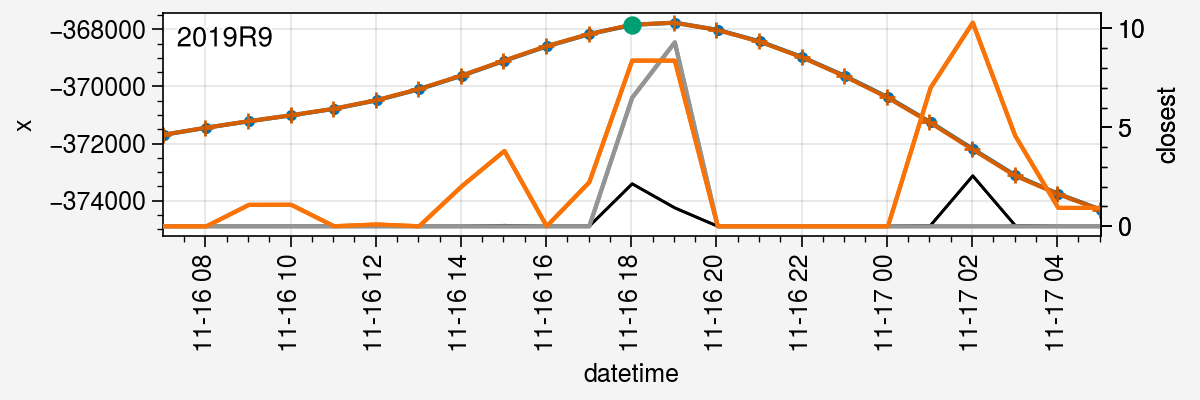

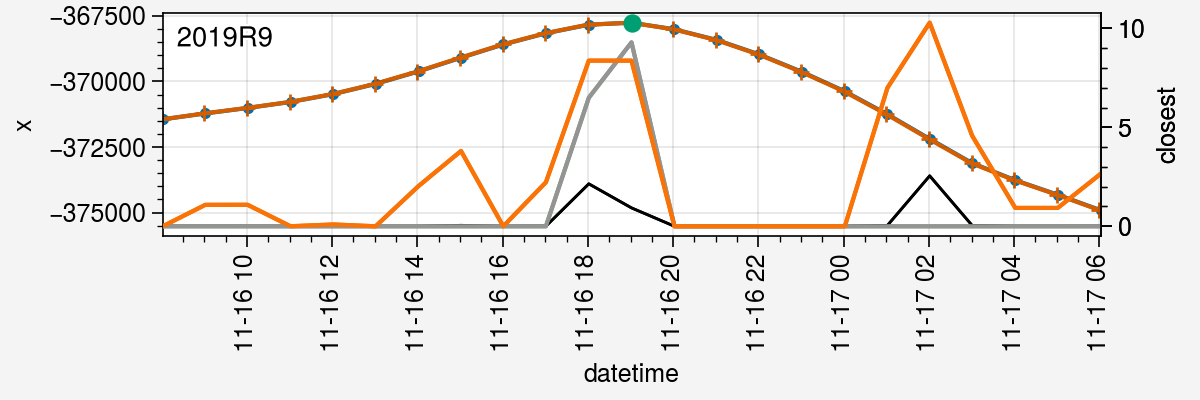

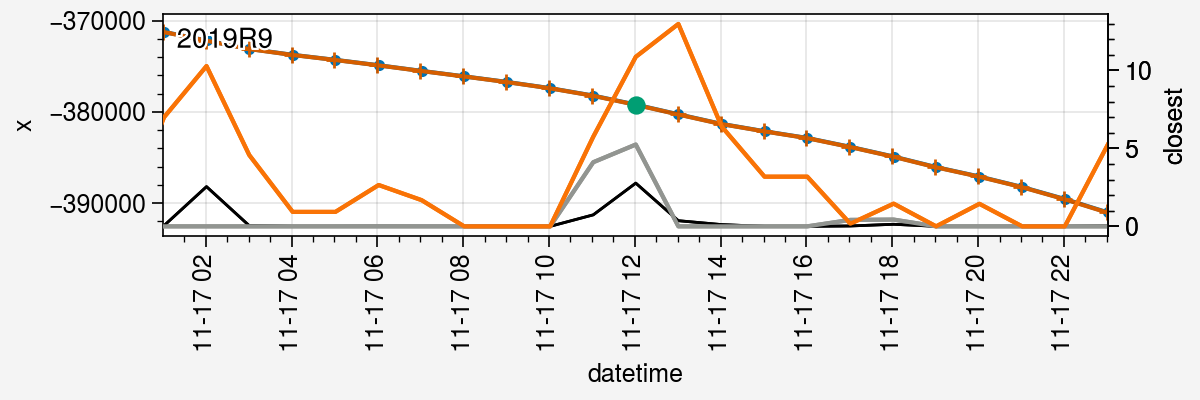

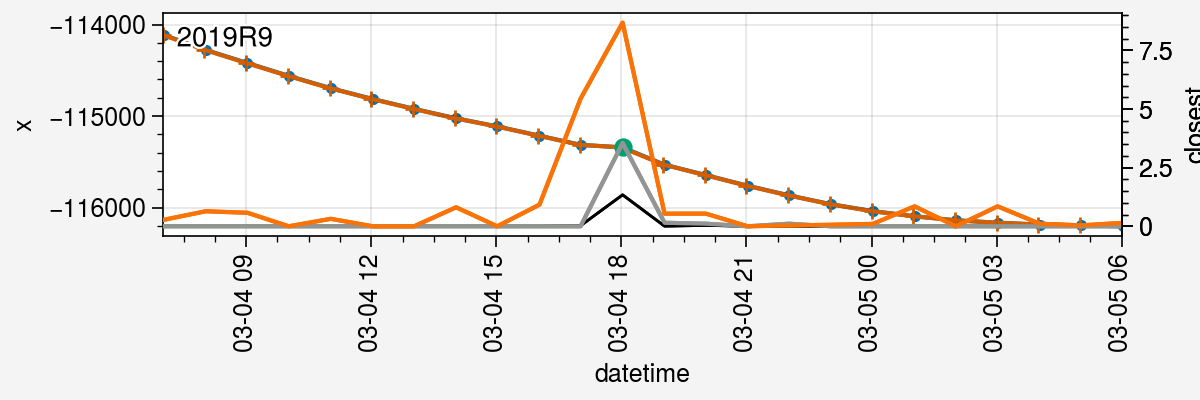

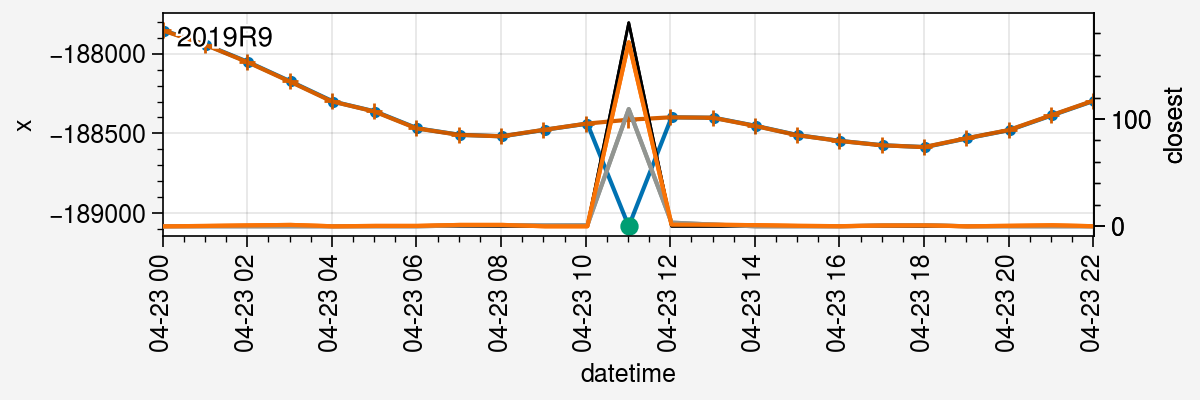

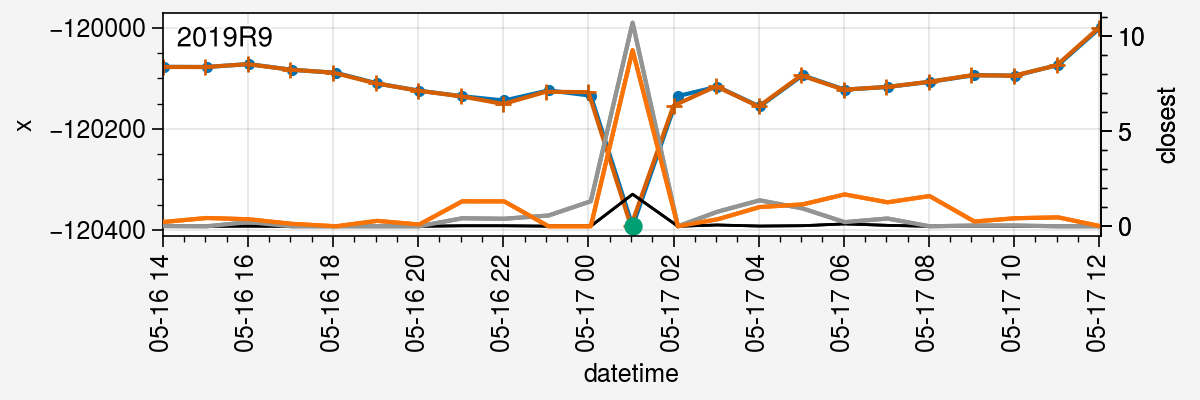

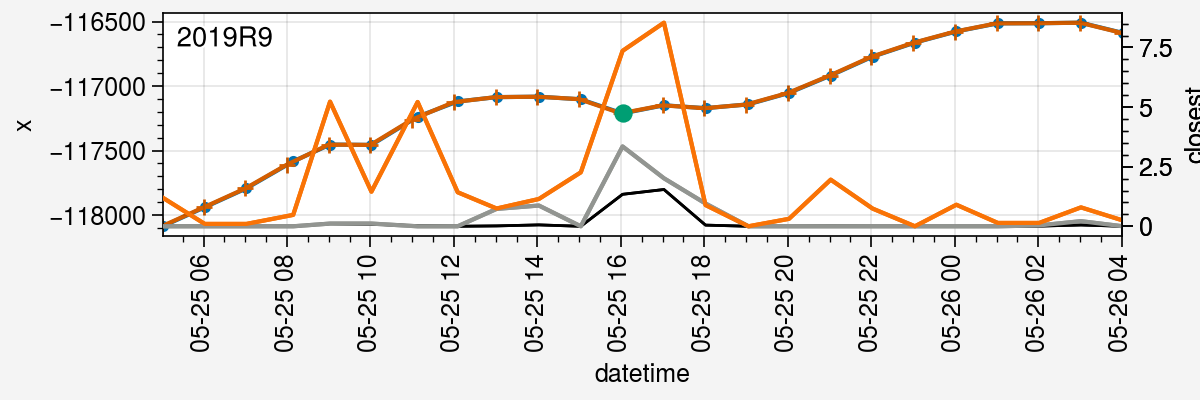

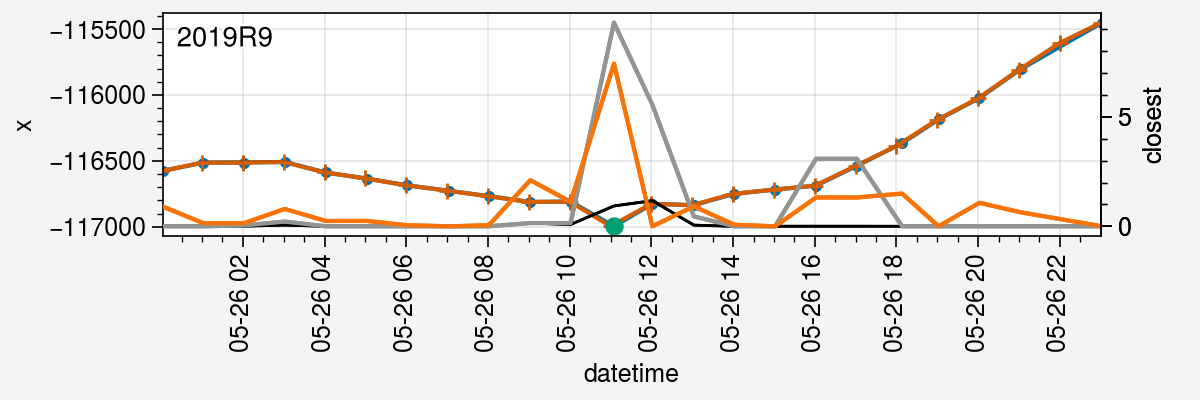

In [210]:
for idx in data.loc[flags].index:
    fig, ax = pplt.subplots(width=6, height=2)
    ax.plot(data.loc[slice(idx-margin, idx+margin), 'x'], marker='.',zorder=0)
    ax.plot(data_interp.loc[slice(idx-margin, idx+margin), 'x'], marker='+', zorder=1)
    ax.scatter(idx, data.loc[idx, 'x'], marker='o', zorder=2)
    
    ax2 = ax.twinx()
    ax2.plot(data.loc[slice(idx-margin, idx+margin), 'closest'], color='black', lw=1)
    ax2.plot(data.loc[slice(idx-margin, idx+margin), 'dist_from_median_xy'], color='gray')
    ax2.plot(data.loc[slice(idx-margin, idx+margin), 'dist_from_median_uv'], color='orange')
    ax2.format(ultitle=buoys[buoy_idx])
    

In [190]:
data.loc[flags].index

DatetimeIndex(['2019-10-27 07:30:00', '2019-10-30 07:20:00',
               '2019-10-31 15:40:00', '2019-10-31 15:50:00',
               '2019-11-01 07:10:00', '2019-12-17 00:50:00',
               '2019-12-17 01:00:00', '2020-01-09 22:50:00',
               '2020-01-09 23:00:00', '2020-01-09 23:10:00',
               '2020-01-18 22:40:00', '2020-02-01 22:10:00',
               '2020-02-13 19:50:00', '2020-02-13 20:01:00',
               '2020-04-24 15:00:00', '2020-04-24 15:10:00',
               '2020-05-20 00:39:59', '2020-05-28 06:50:01',
               '2020-06-10 23:09:59', '2020-06-21 03:59:59',
               '2020-06-28 07:30:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)

In [162]:
import numpy as np
import proplot as pplt
from sklearn.linear_model import LinearRegression
from patsy import cr

buoy_idx

15

In [423]:
for idx, buoy in enumerate(buoys):
    if buoy == '2019O5':
        print(idx)

205


In [540]:
bad_data = {'2019P142': ['2020-04-04 14:30:00', '2020-05-25 01:00:00', '2020-07-23 00:59:59'], #1
            '2019R9': ['2020-05-17 01:02:20', '2020-04-23 11:01:09', '2020-05-25 16:02:24'], #0
            '2020P171': ['2020-12-13 00:04:00', '2021-01-08 20:04:01','2021-01-08 16:04:02'], #10\
            '2019P119': ['2020-02-24 04:56:04', '2020-02-25 04:56:04'],
            '2020P178': ['2021-01-21 13:00:28'],
            '2019O5': ['2019-10-27 07:30:00', '2019-10-30 07:20:00', #205: first is subtle
               '2019-10-31 15:40:00', '2019-10-31 15:50:00',
               '2019-11-01 07:10:00', '2019-12-17 00:50:00',
               '2019-12-17 01:00:00', '2020-01-09 22:50:00',
               '2020-01-09 23:00:00', '2020-01-09 23:10:00',
               '2020-01-18 22:40:00', '2020-02-01 22:10:00',
               '2020-02-13 19:50:00', '2020-02-13 20:01:00',
               '2020-04-24 15:00:00', '2020-04-24 15:10:00',
               '2020-05-20 00:39:59', '2020-05-28 06:50:01',
               '2020-06-10 23:09:59', '2020-06-21 03:59:59',
               '2020-06-28 07:30:00']
           } 

In [245]:
# Cubic splines works really well for good data - error is in the range of the device error (~10 m)
margin = pd.to_timedelta('12H')
buoys = [b for b in buoys_interp]
print(buoys[buoy_idx])
data = buoy_data[buoys[buoy_idx]]
index = data.dropna().index

bad_data[buoys[buoy_idx]]

2019R9


['2020-05-17 01:02:20', '2020-04-23 11:01:09']

In [400]:
def fit_splines(date, data, xvar='x', yvar='y', df=25):
    """Fit regression model using natural cubic splines after
    removing 'date', and evaluate at 'date'.
    Returns dataframe with columns xvar, yvar, xvar_hat, yvar_hat,
    and err = sqrt((x-xhat)^2 + (y-yhat)^2)"""
    data_fit = data.drop(date)
    tfit = data_fit.index
    xfit = (tfit - tfit[0]).total_seconds()
    yfit = data_fit[[xvar, yvar]]
    x_basis = cr(xfit, df=df, constraints="center")
    model = LinearRegression().fit(x_basis, yfit)
    
    t = data.index
    x = (t - t[0]).total_seconds()
    y = data[[xvar, yvar]]
    x_basis = cr(x, df=df, constraints="center")
    
    y_hat = model.predict(x_basis)
    fitted = pd.DataFrame(y_hat, index=t, columns=[xvar + '_hat', yvar + '_hat'])
    fitted[xvar] = y[xvar]
    fitted[yvar] = y[yvar]
    fitted['err'] = np.sqrt((fitted[xvar + '_hat'] - fitted[xvar])**2 + (fitted[yvar + '_hat'] - fitted[yvar])**2)
    return fitted.loc[:, [xvar, yvar, xvar + '_hat', yvar + '_hat', 'err']]

def test_point(date, data, xvar, yvar, df, fit_window, sigma):
    """Tests whether a point is within the expected range of a smoothed path.
    The smoothed path is computed by fitting a regression model with natural
    cubic splines on the data within (date-fit_window, date+fit_window) excluding
    the test point. The distance between the point and the predicted position of
    the point is compared to sigma * the standard deviation of the residual. Returns
    True if the distance is greater, False if less."""
    
    margin = pd.to_timedelta(fit_window)
    if type(date) == str:
        date = pd.to_datetime(date)
    fit_ts = slice(date - margin, date + margin)
    fit_df = fit_splines(date, data.loc[fit_ts], xvar, yvar, df)
    
    err_stdev = fit_df.drop(date)['err'].std()
    fit_df['flag'] = fit_df['err'] > (sigma * err_stdev)
    return fit_df

In [532]:
buoy_idx = 1
print(buoys[buoy_idx])
data = buoy_data[buoys[buoy_idx]]

2019P142


In [557]:
%%time
print(buoys[buoy_idx])
data = buoy_data[buoys[buoy_idx]]
data['flag'] = 0
df = 31
test_dates = data.loc[slice(data.index.min() + margin, data.index.max() - margin)].index
#test_dates = [date]
for date in test_dates:
#    if date > pd.to_datetime('2020-05-25 16:02:24'):
    test_fit = test_point(date, data.loc[data['flag'] != 1], 'x', 'y', df=df, fit_window='48H', sigma=10)
    if test_fit.loc[date, 'flag']:
        # Don't flag points right next to large gaps
        # TBD: Implement method to check error prior to gaps
        t = test_fit.index.to_series()
        dt_next = t.shift(-1) - t
        dt_prior = t - t.shift(1)
        gap_threshold = pd.to_timedelta('4H')
        if (dt_next[date] < gap_threshold) & (dt_prior[date] < gap_threshold):
            data.loc[date, 'flag'] = 1
            print('Flagged date ', date)
            
buoy_data[buoys[buoy_idx]]['flag'] = data['flag']

2019P142
Flagged date  2020-05-25 01:00:00
CPU times: user 16.8 s, sys: 39.2 ms, total: 16.8 s
Wall time: 16.8 s


# What do the undesired flags have in common?
## Buoy 2019T66 
Feb case: precedes gap
May 1st case: Standard deviation of error within window is quite low (10-30 m.
August 10th case: similar, 50-60 m.
Raising the sigma level to 10 allows these points through (no flags). Result for P142 and R9?

## Buoy 2019R9
- Still catches the April case with sigma = 10

## Buoy 2019P142
May cases: those that stay flagged are either pre-gap or actually bad data

In [535]:
bad_data['2019P142']

['2020-04-04 14:30:00', '2020-05-25 01:00:00', '2020-07-23 01:00:00']

In [564]:
buoy_idx = 205
data = buoy_data[buoys[buoy_idx]]
for date in bad_data[buoys[buoy_idx]]:
    date = pd.to_datetime(date)
    timeslice = slice(date - margin, date + margin)
    xvar = 'x'
    yvar = 'y'
    test_fit = test_point(date, data, xvar, yvar, df=29, fit_window='48H', sigma=6)

    print(date, np.round(test_fit.drop(date)['err'].std(),1),
                np.round(test_fit.loc[date, 'err'], 1), test_fit.loc[date, 'flag'])

2019-10-27 07:30:00 9.2 37.5 False
2019-10-30 07:20:00 10.9 104.0 True
2019-10-31 15:40:00 10.4 49.7 False
2019-10-31 15:50:00 9.7 105.2 True
2019-11-01 07:10:00 10.9 65.8 True
2019-12-17 00:50:00 17.2 5.9 False
2019-12-17 01:00:00 16.8 78.5 False
2020-01-09 22:50:00 9.5 18.7 False
2020-01-09 23:00:00 9.3 41.6 False
2020-01-09 23:10:00 9.2 35.3 False
2020-01-18 22:40:00 7.9 26.7 False
2020-02-01 22:10:00 24.2 54.5 False
2020-02-13 19:50:00 20.6 141.5 True
2020-02-13 20:01:00 21.6 12.5 False
2020-04-24 15:00:00 8.0 1.9 False
2020-04-24 15:10:00 8.1 19.0 False
2020-05-20 00:39:59 8.1 40.1 False
2020-05-28 06:50:01 10.9 10.1 False
2020-06-10 23:09:59 11.5 76.9 True
2020-06-21 03:59:59 19.9 2.4 False
2020-06-28 07:30:00 15.2 120.4 True


/opt/miniconda3/envs/drifter/lib/python3.9/site-packages/proplot/ui.py:143: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  return plt.figure(FigureClass=pfigure.Figure, **kwargs)


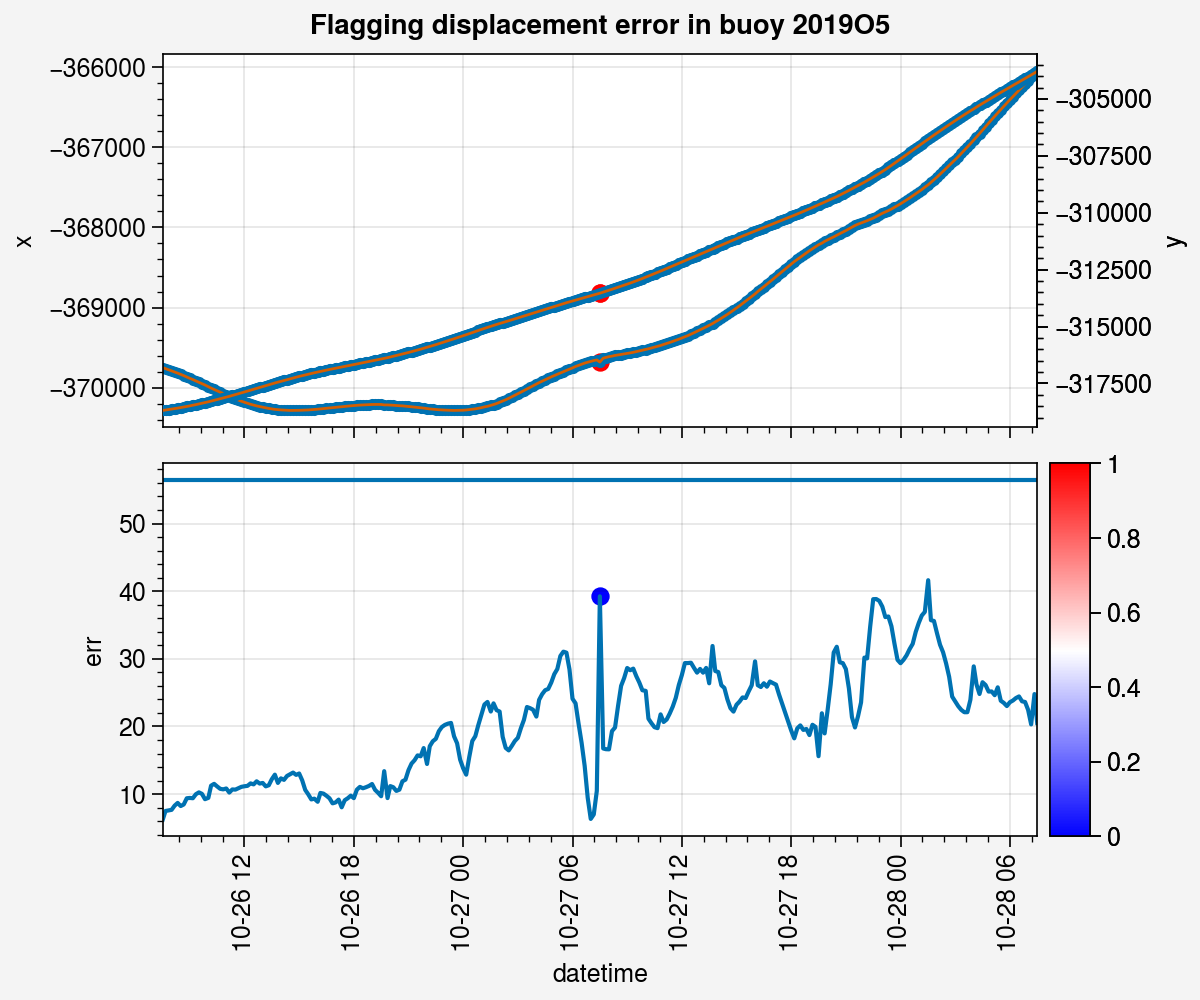

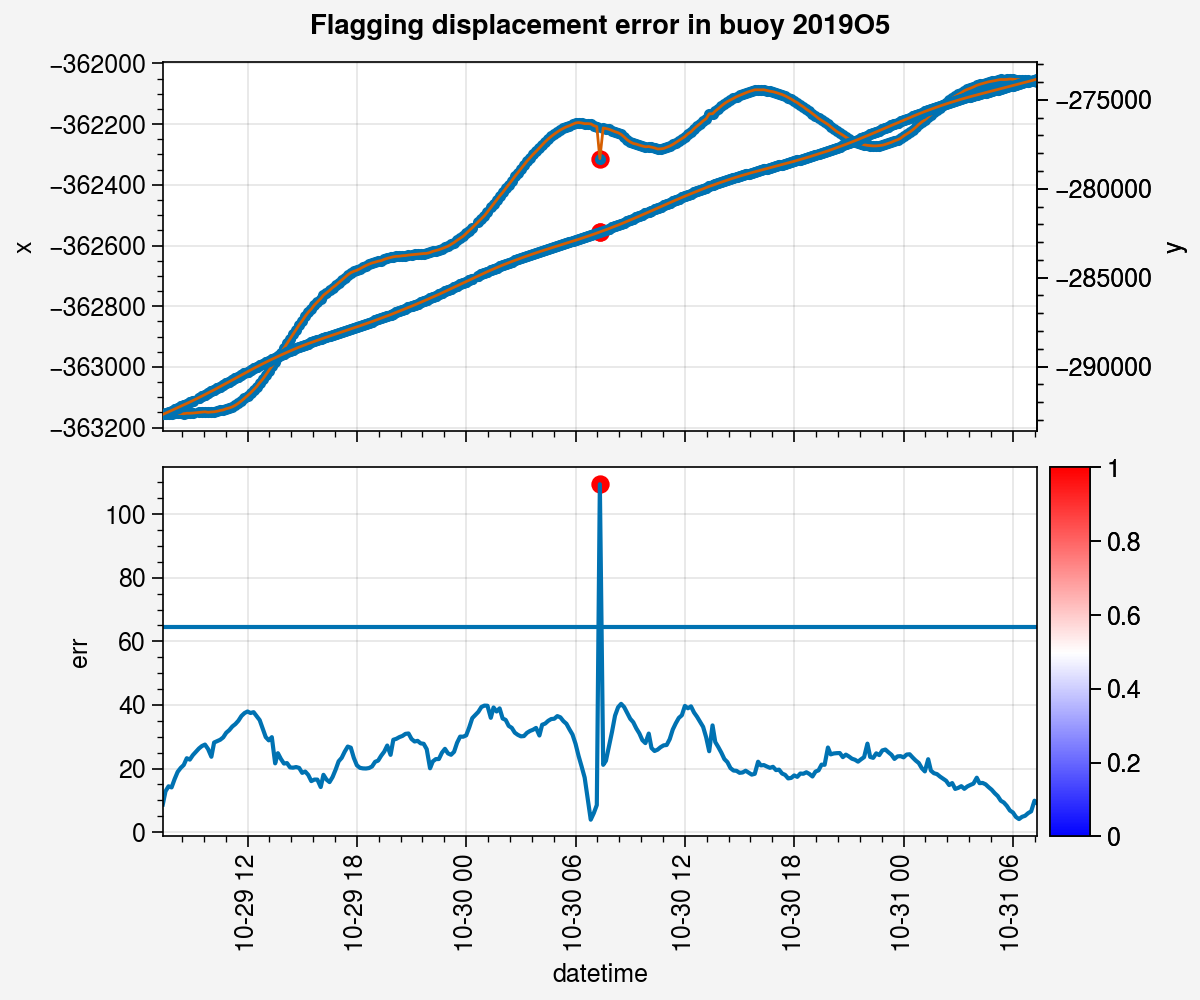

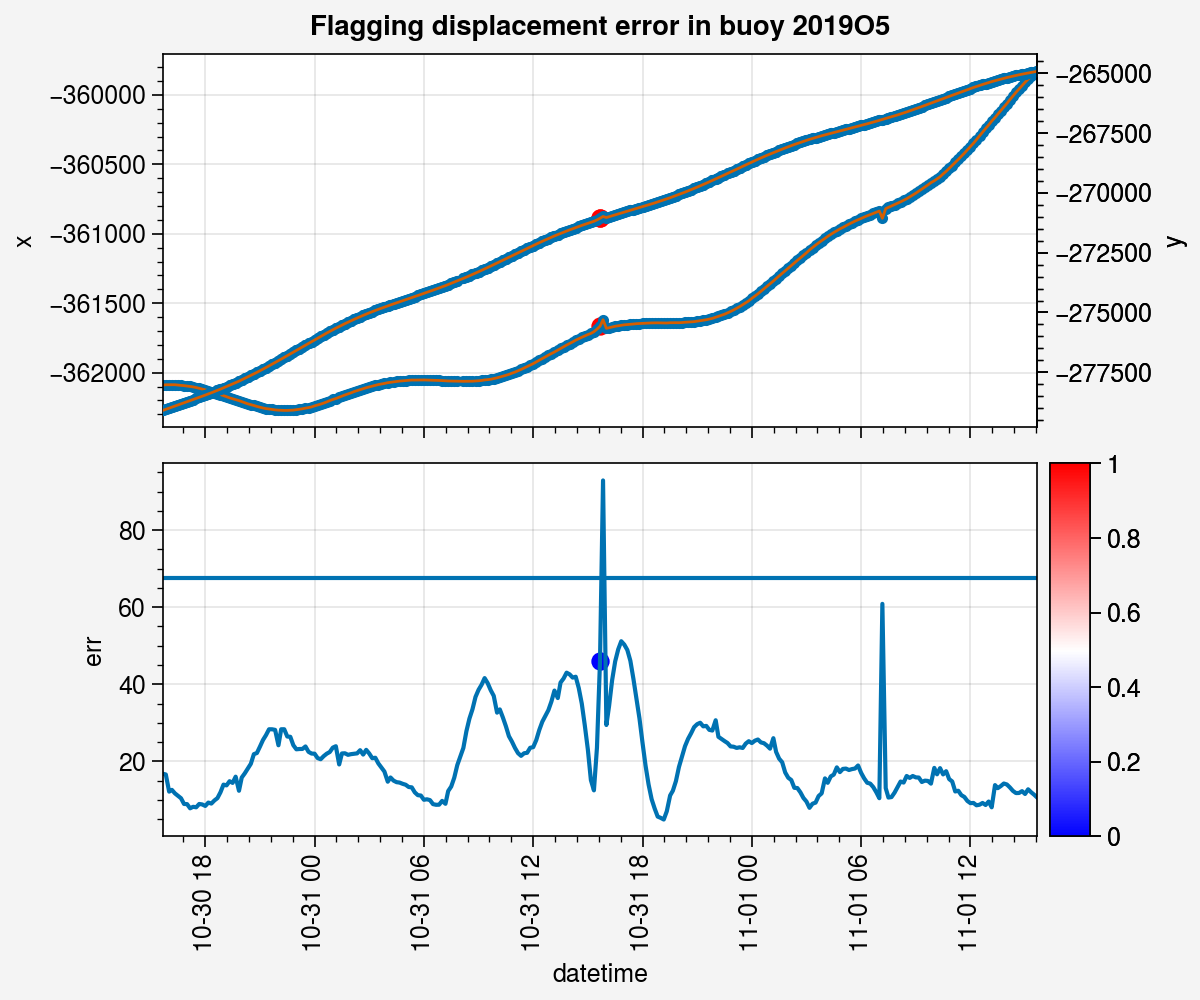

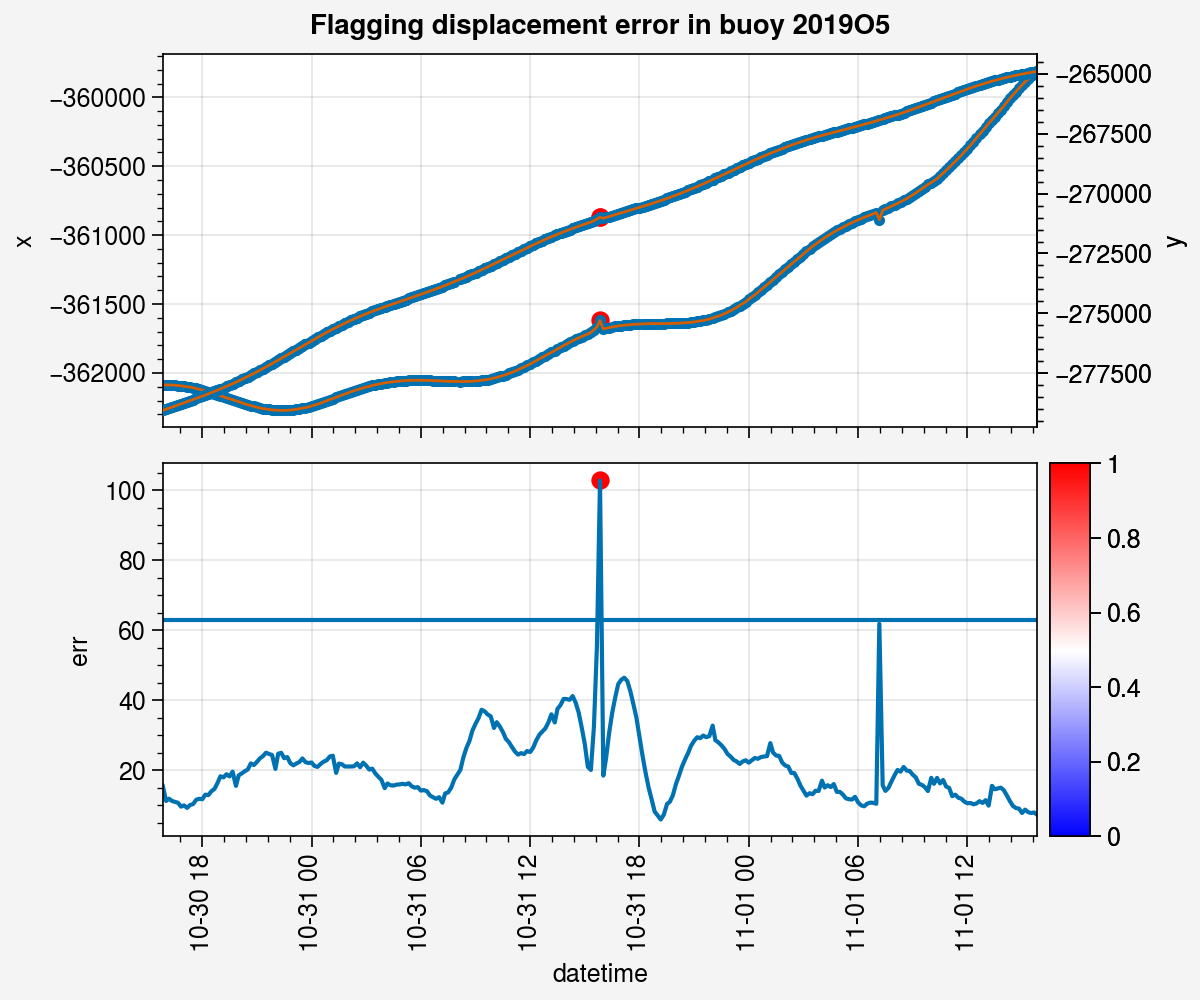

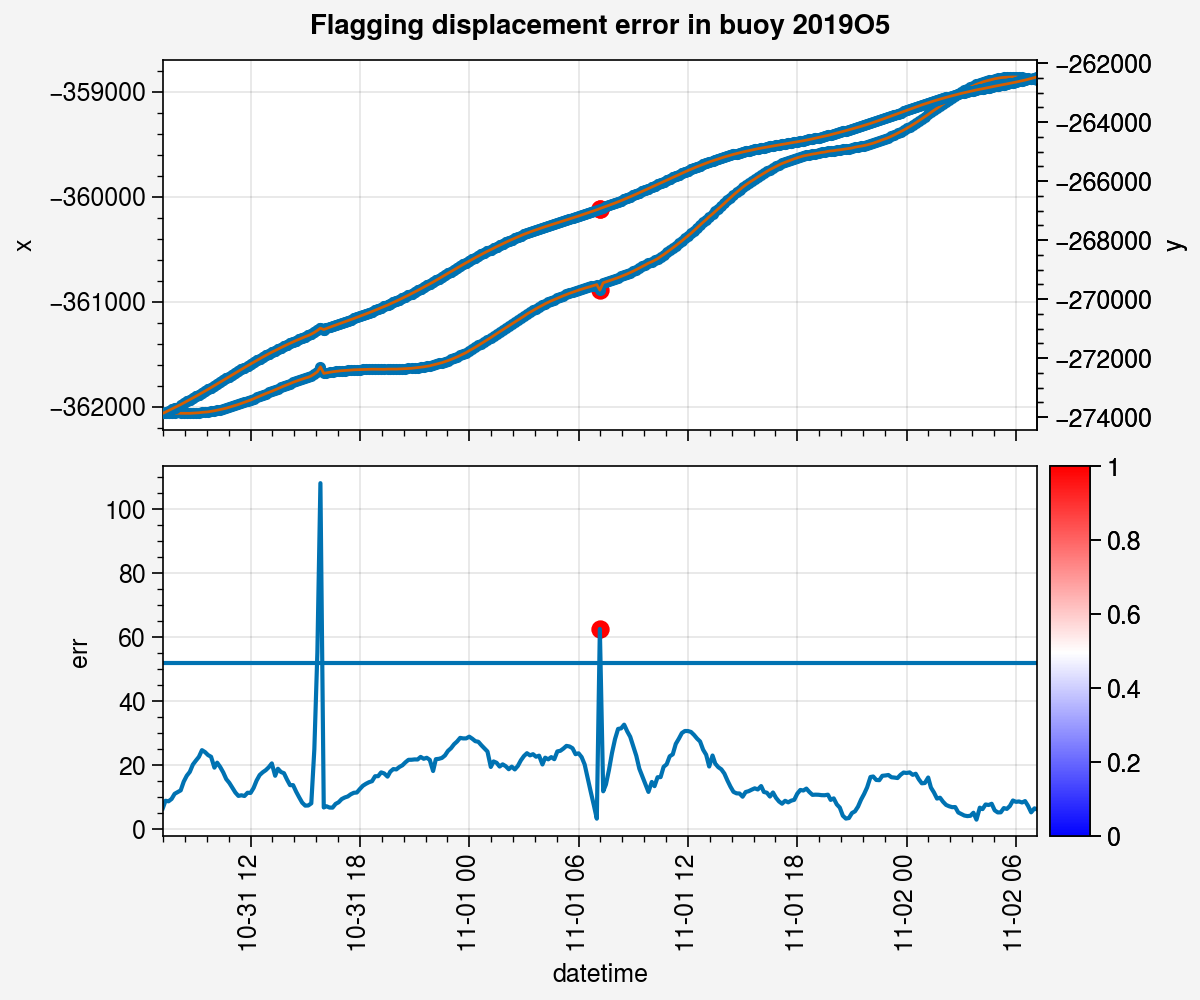

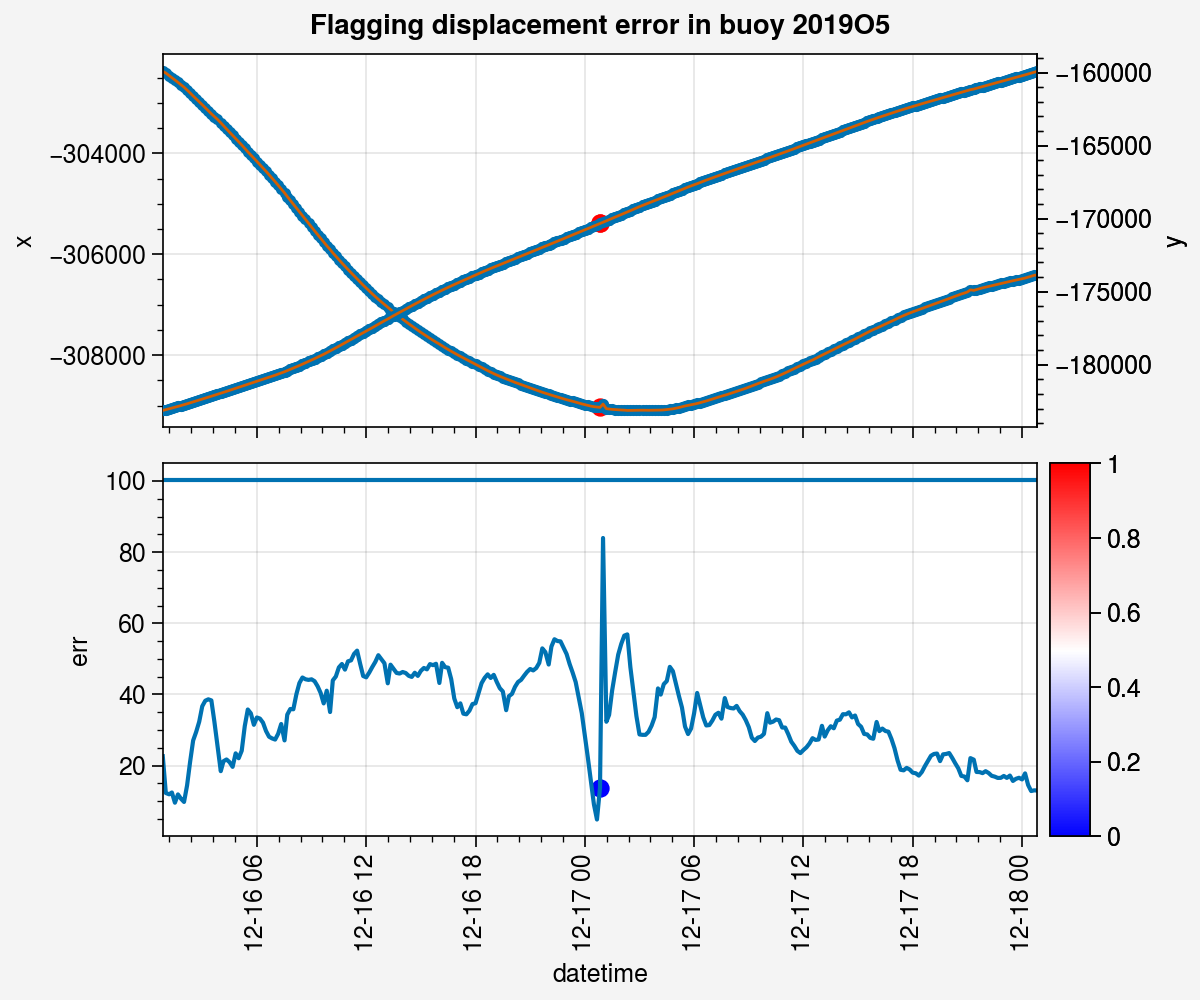

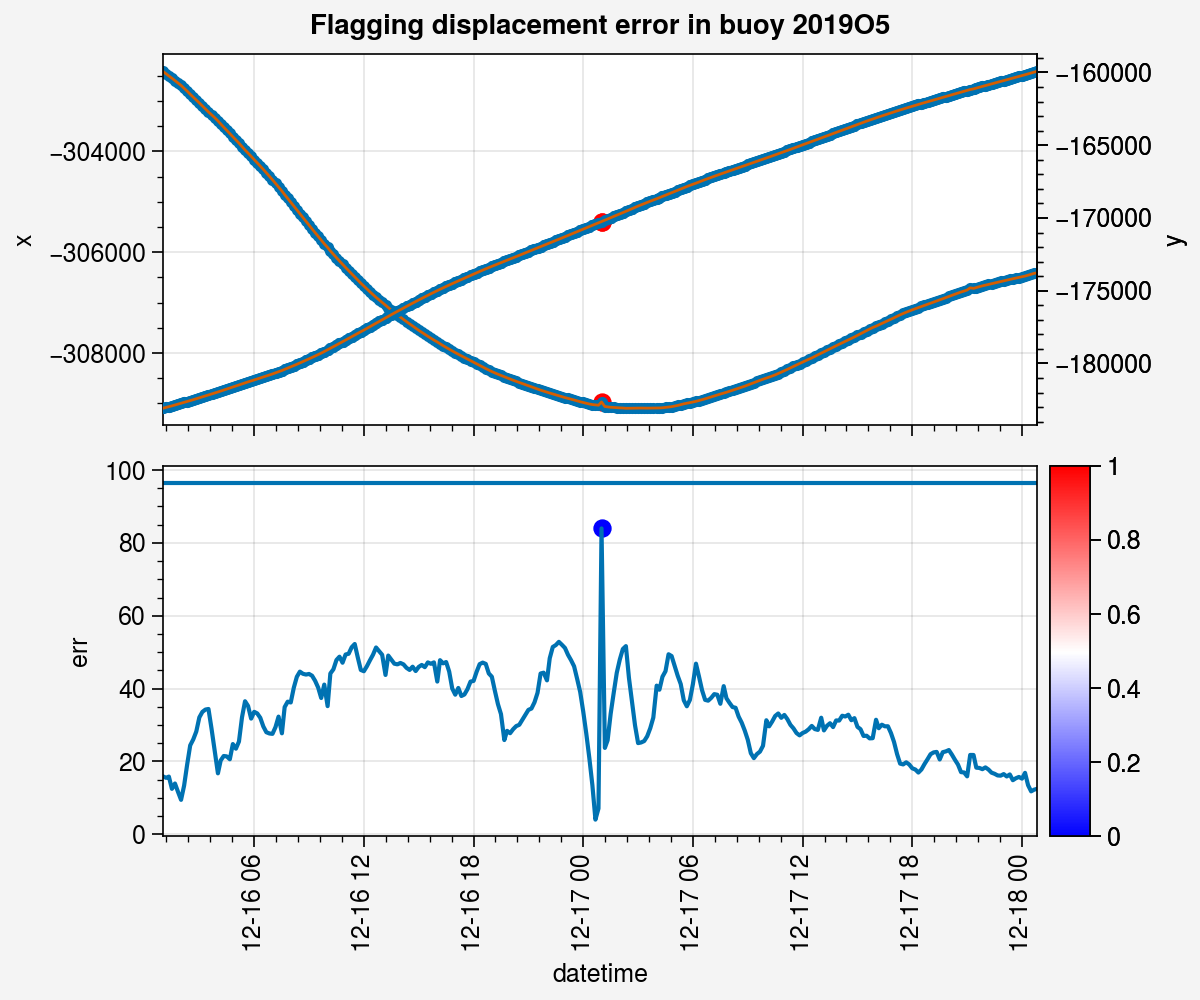

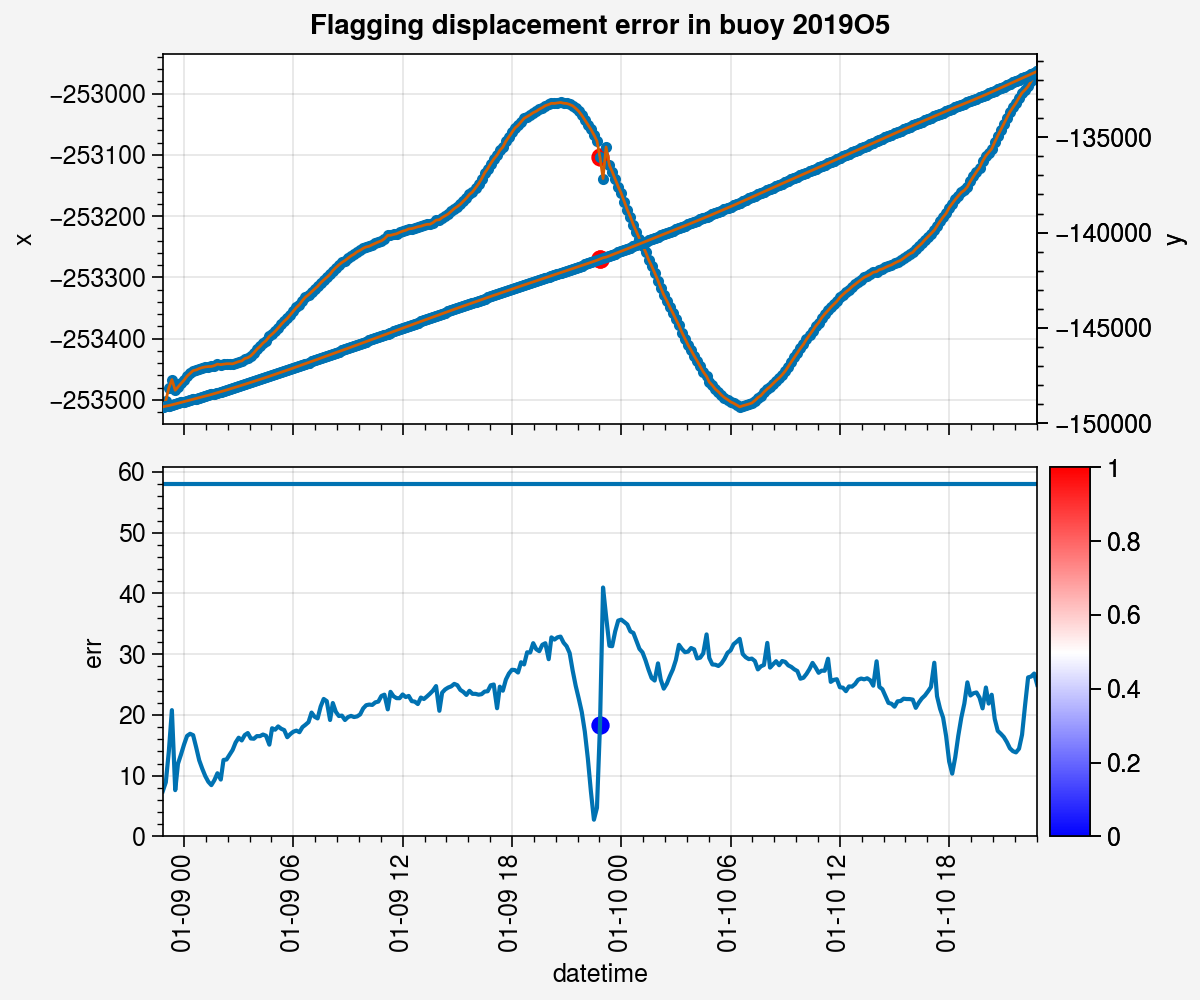

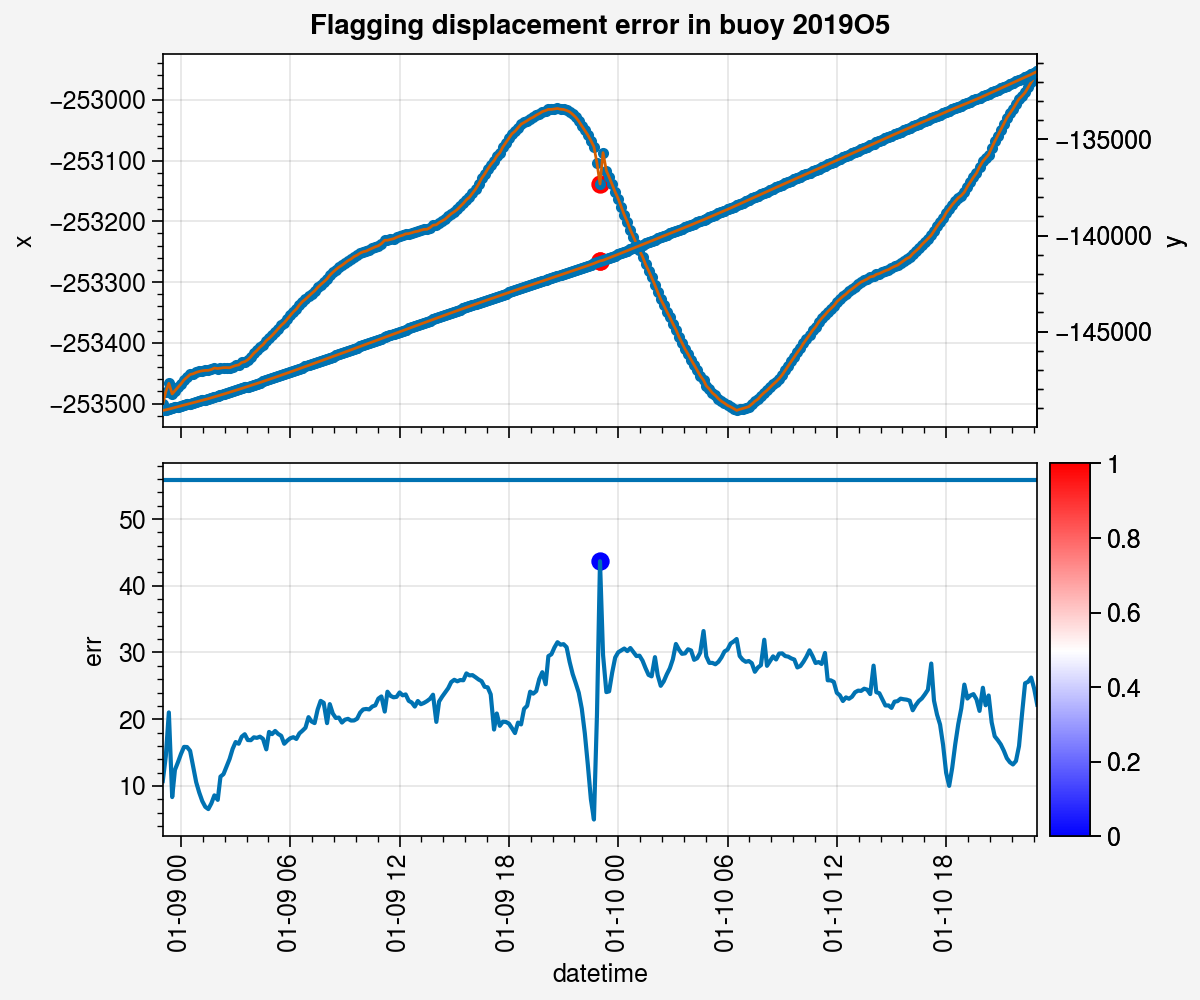

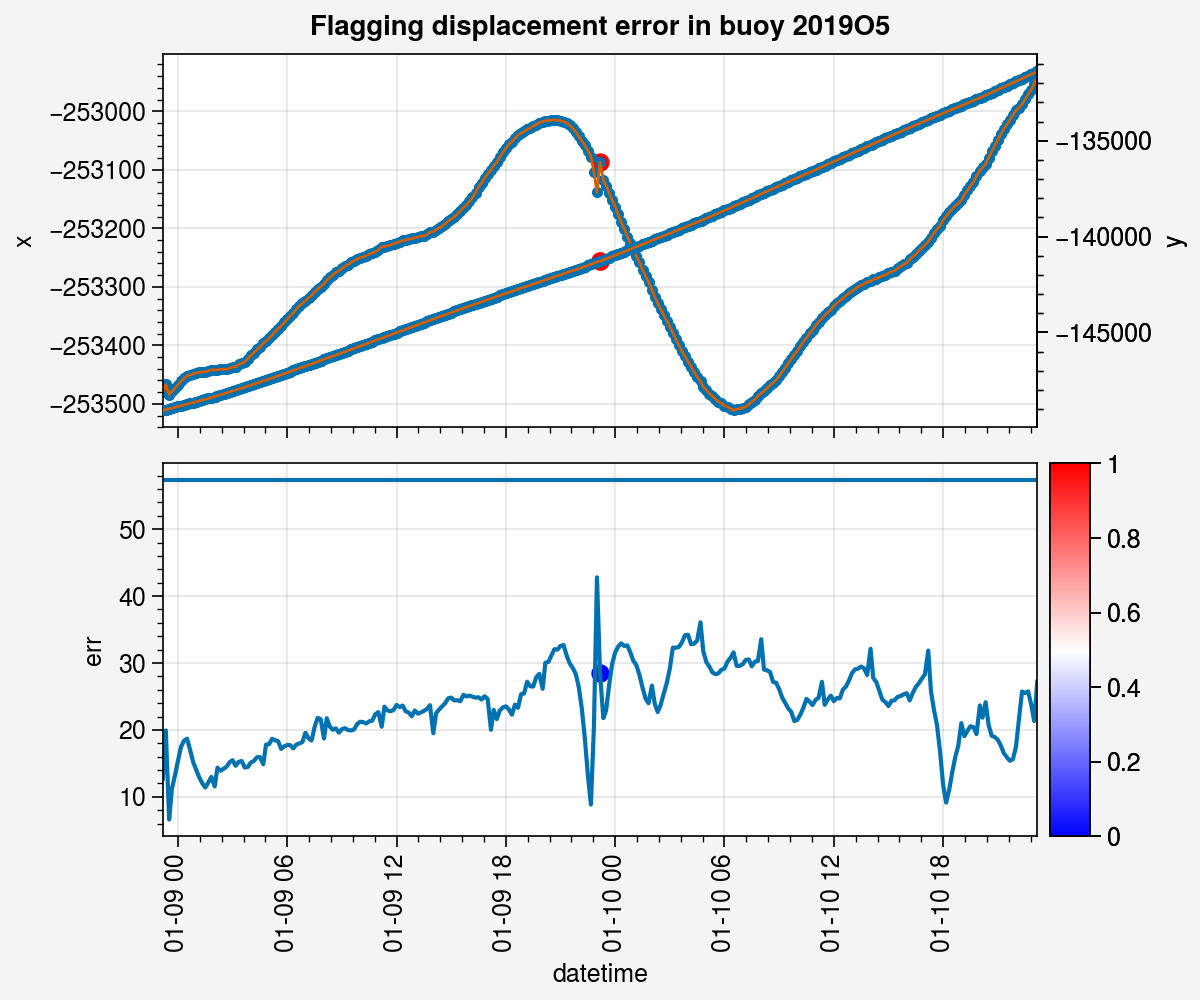

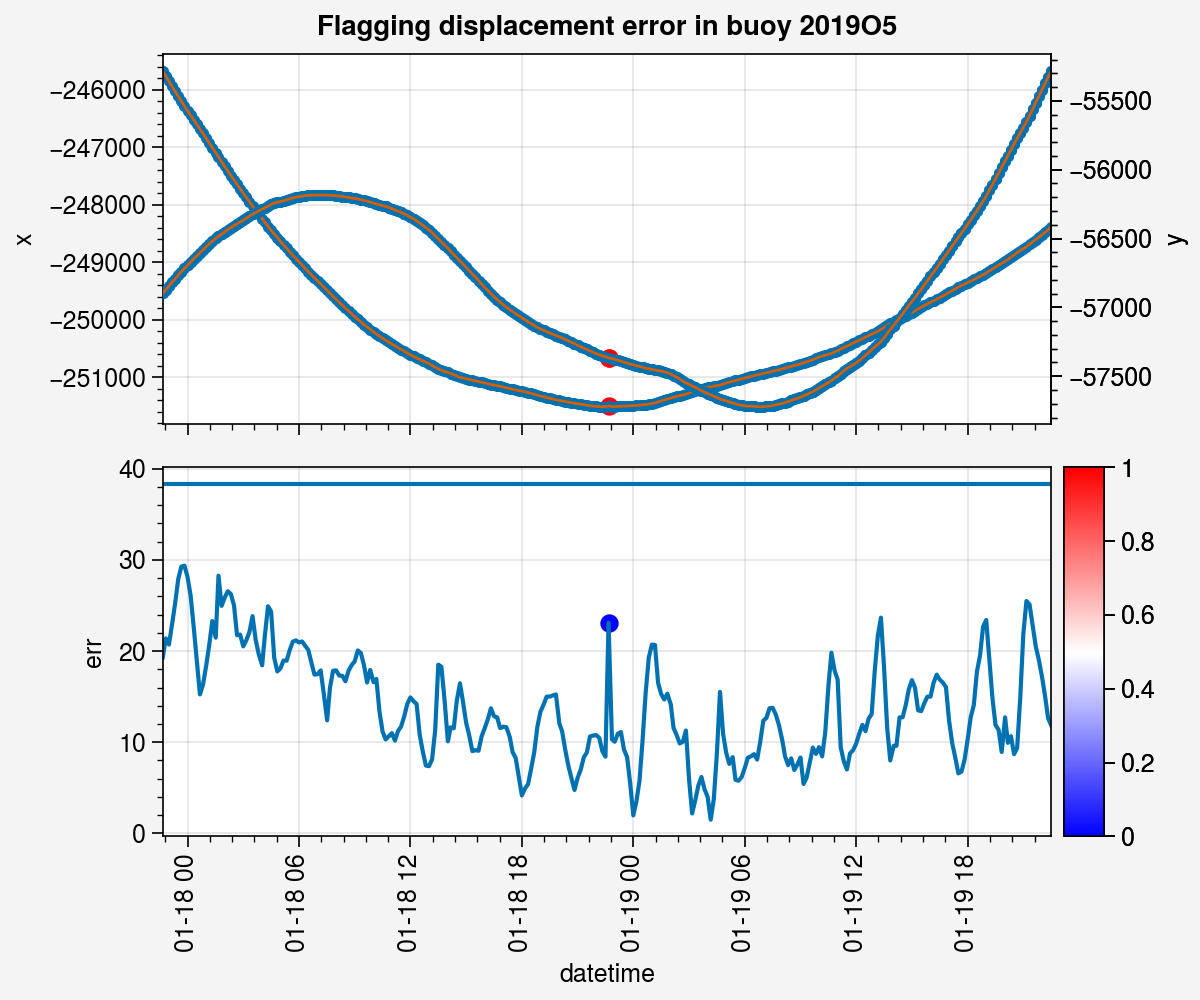

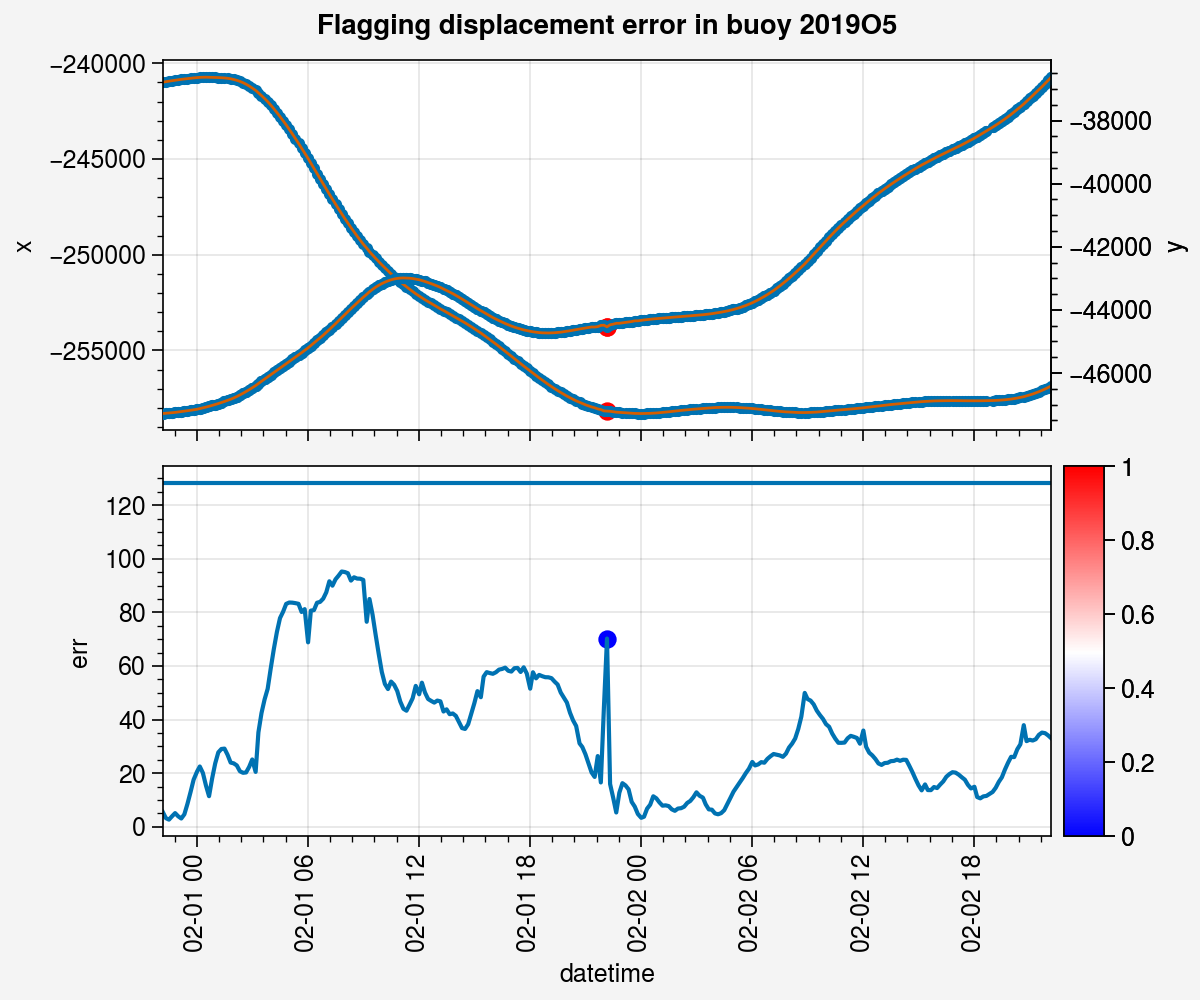

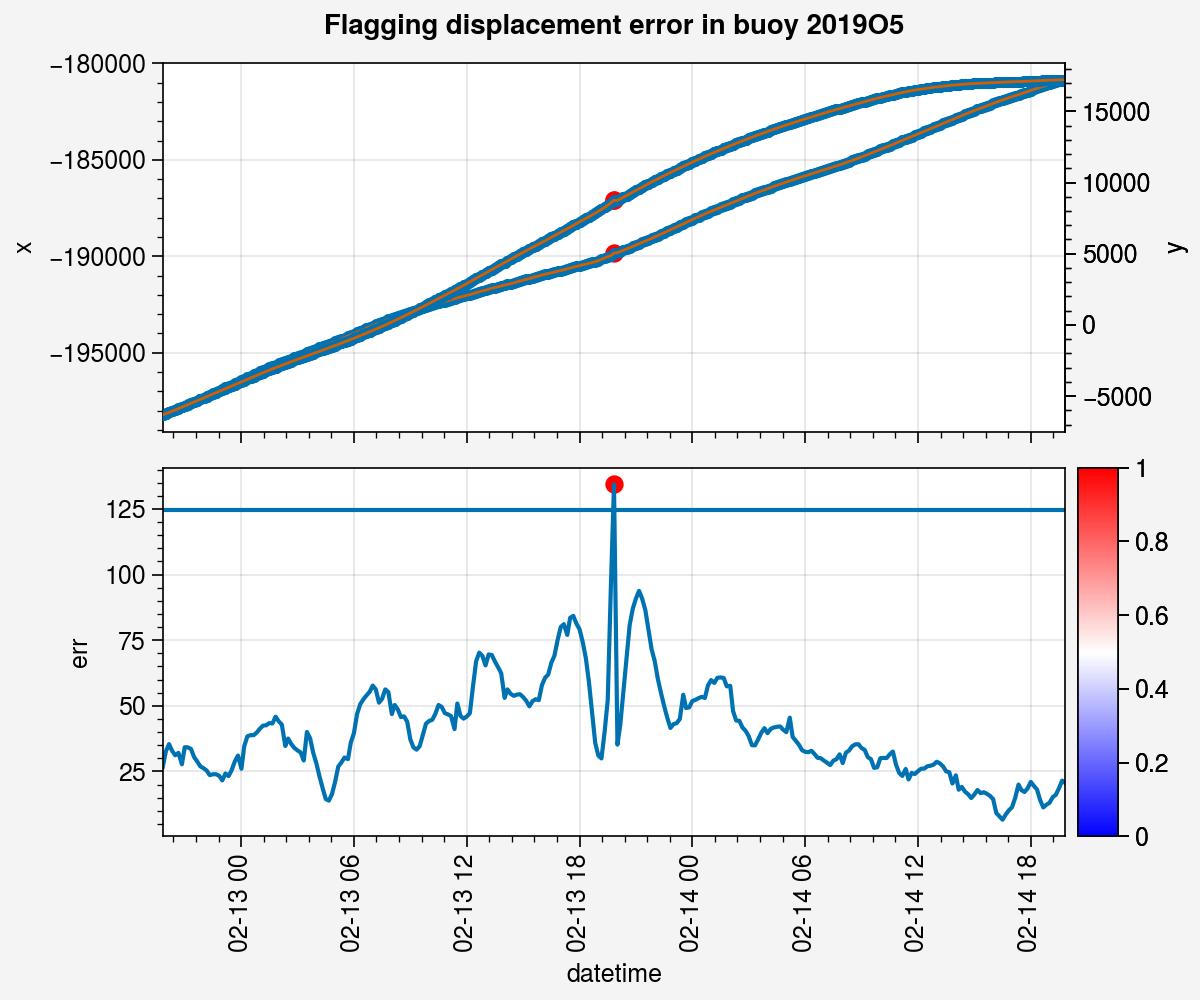

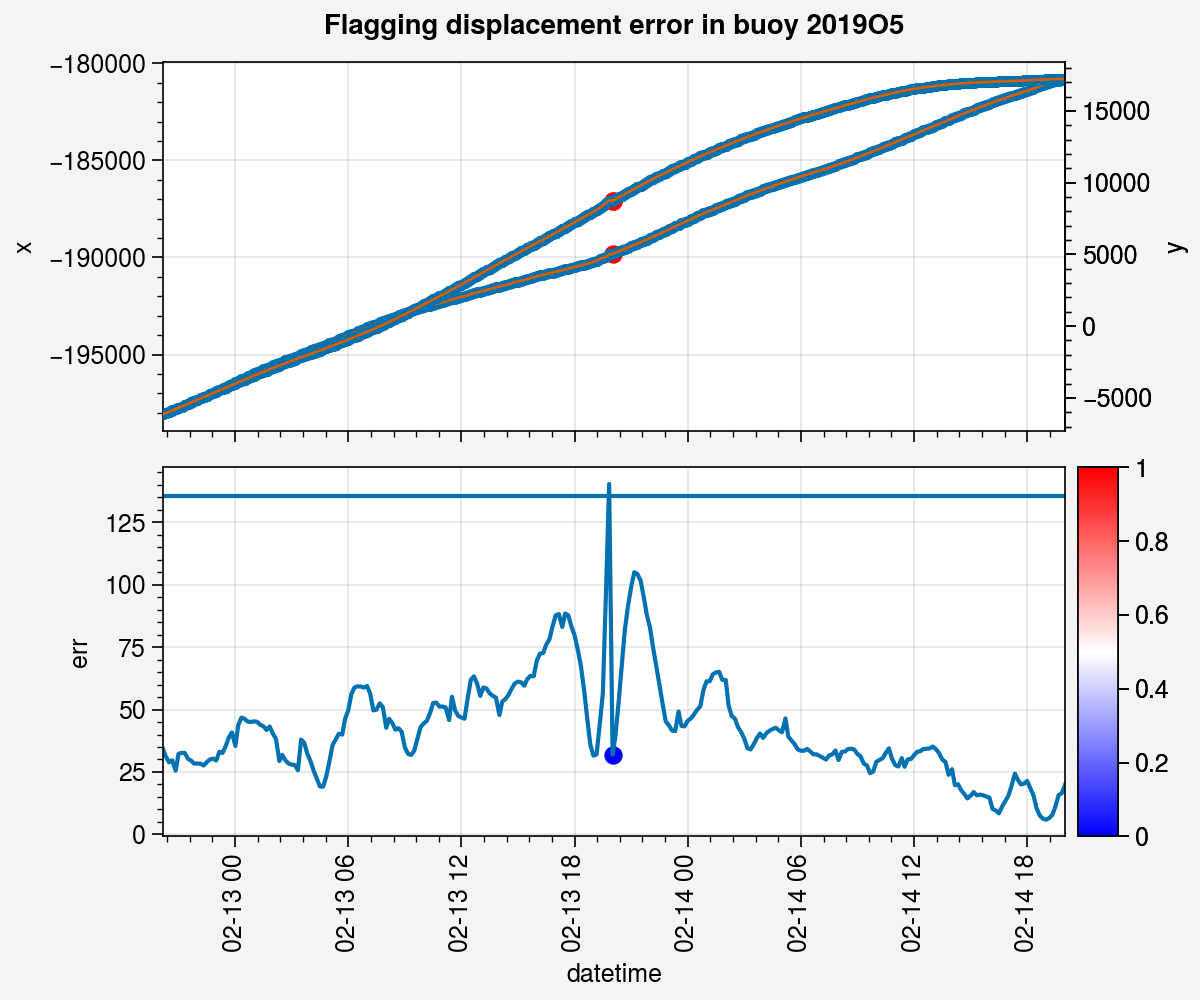

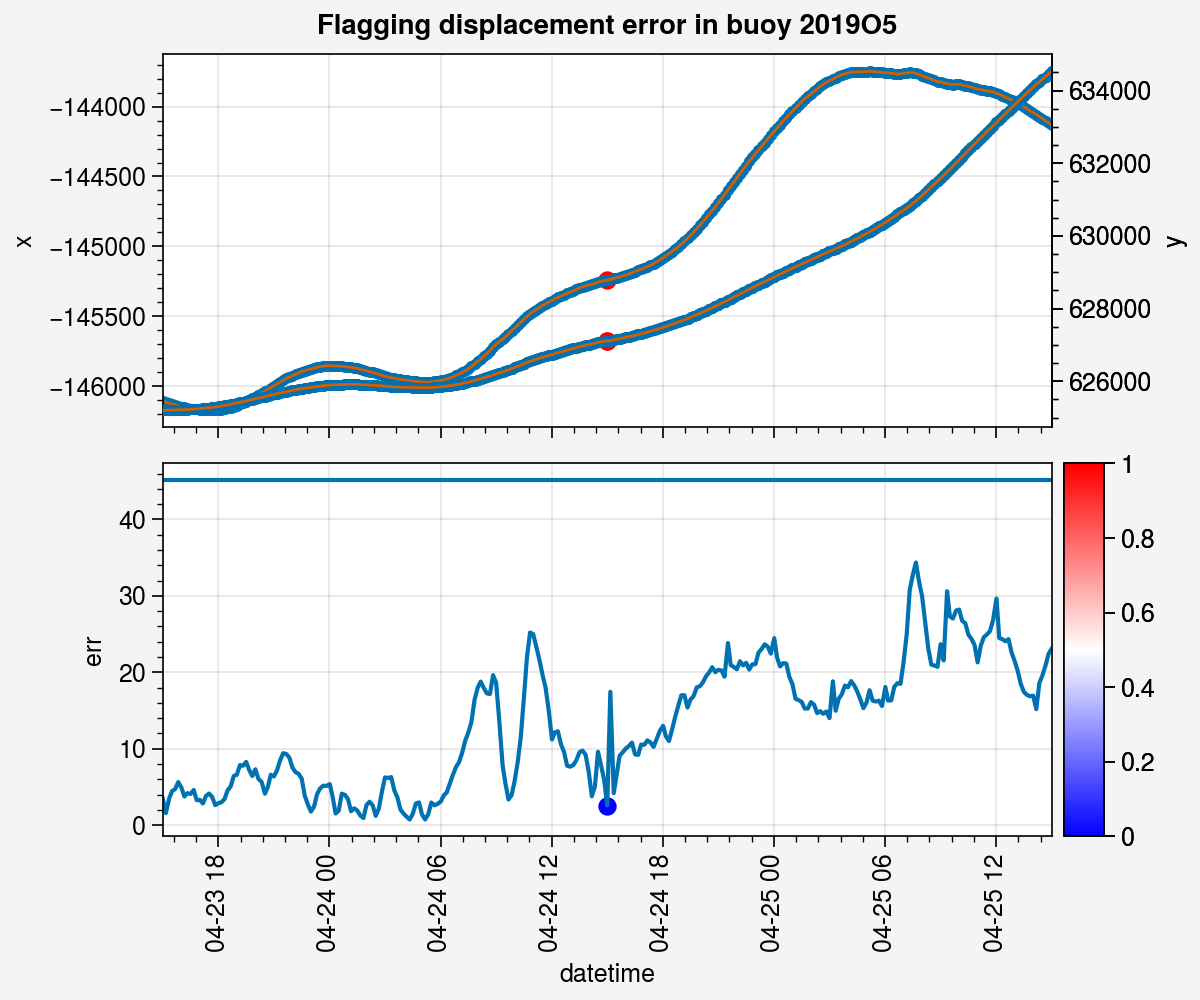

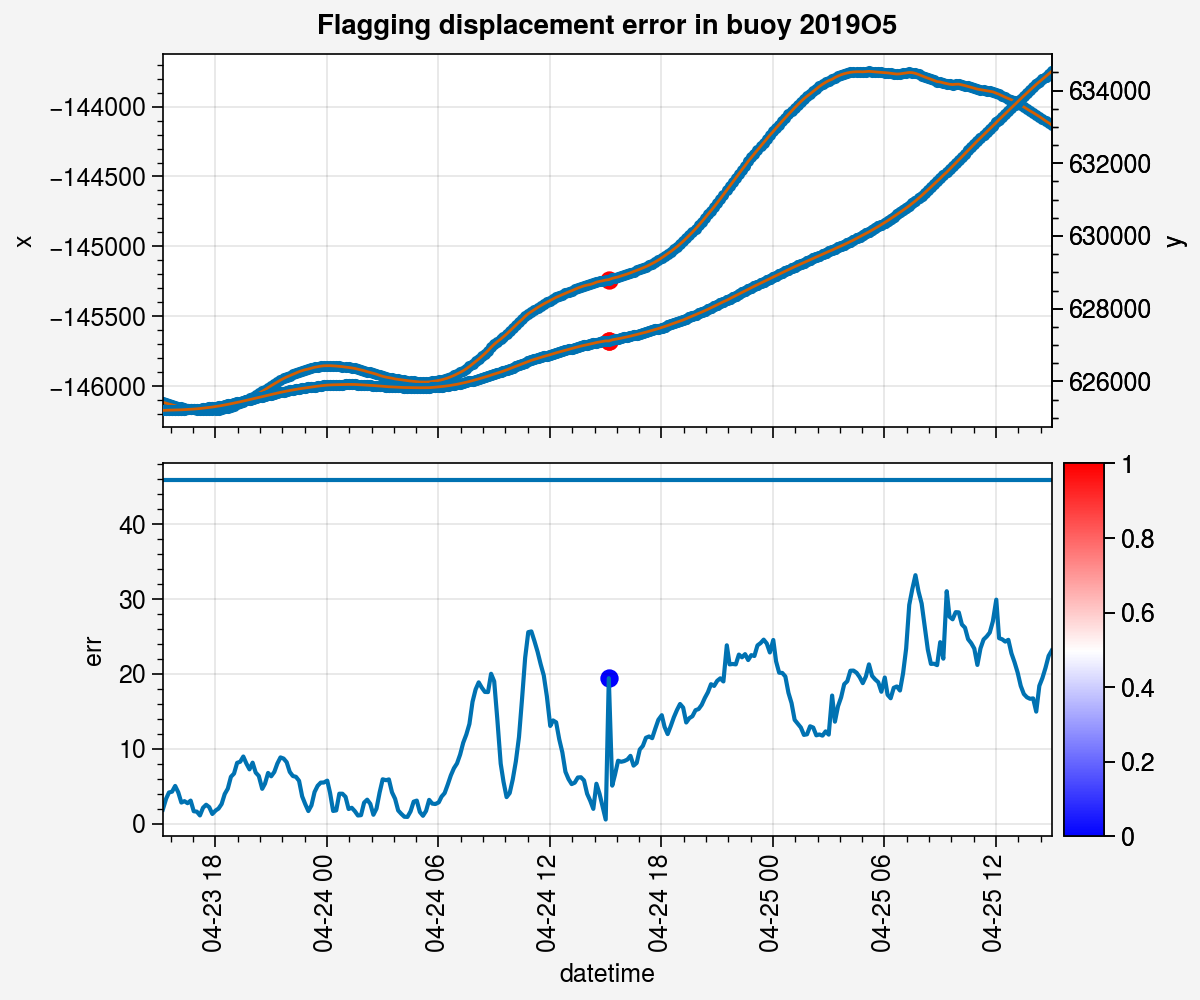

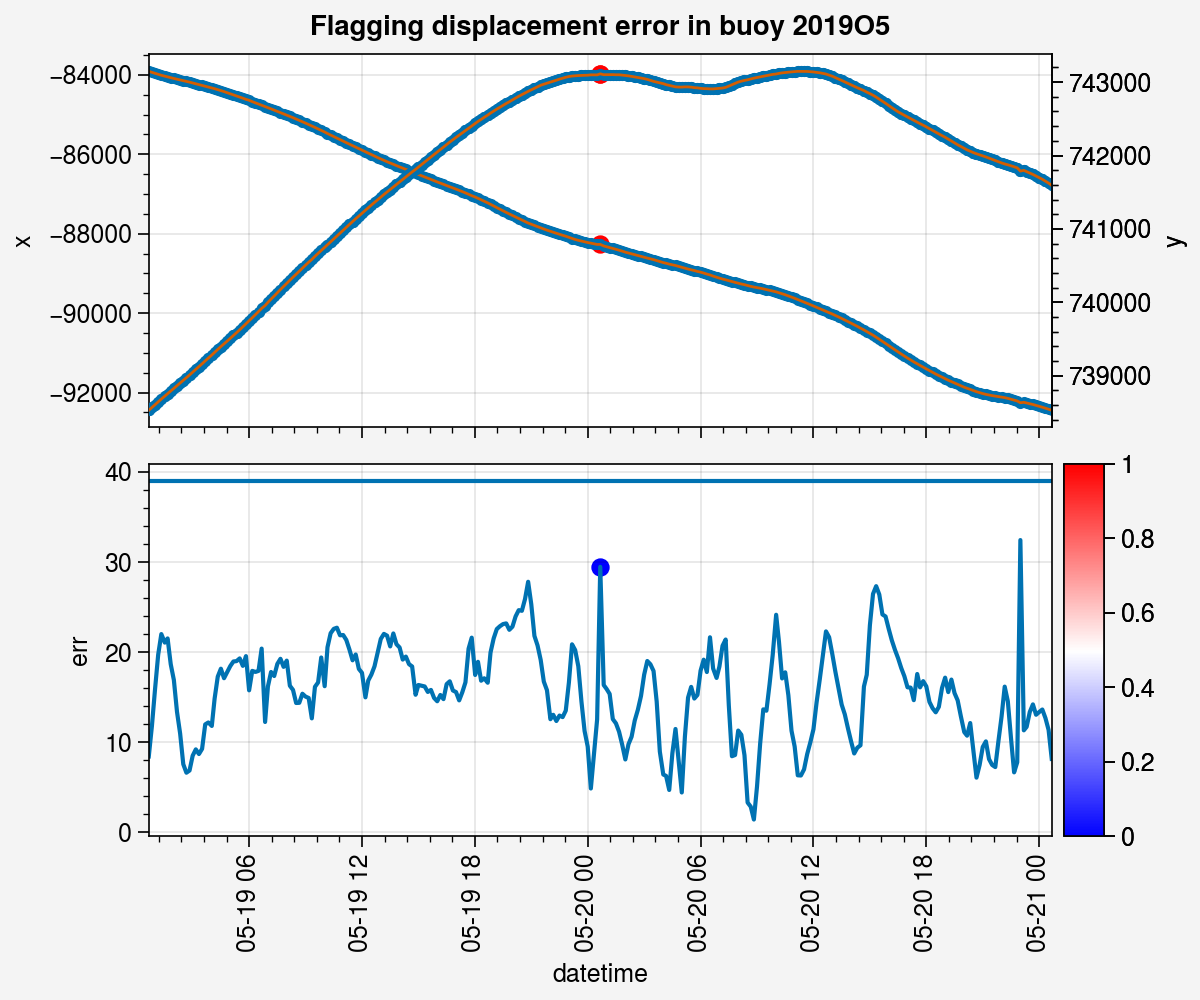

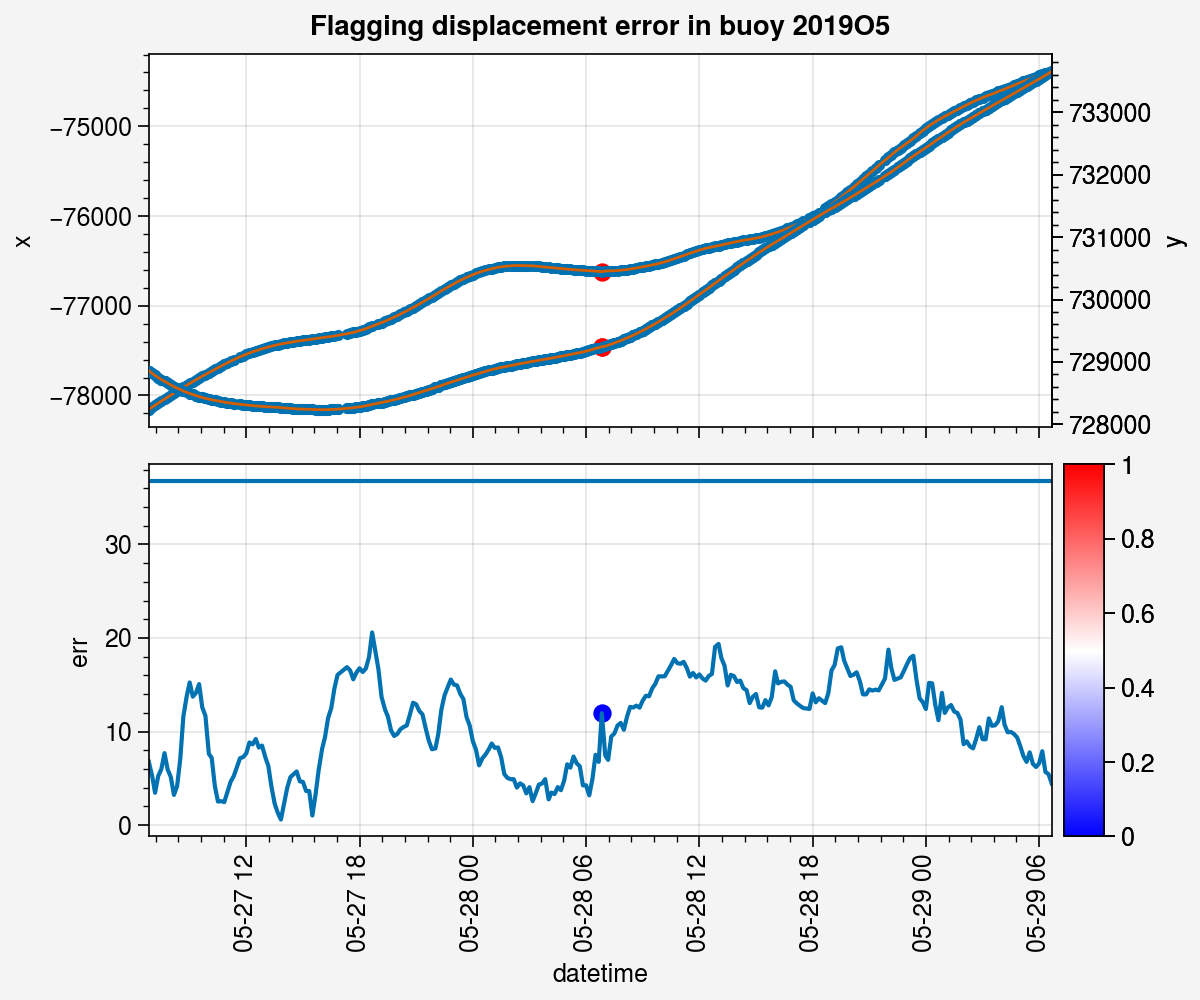

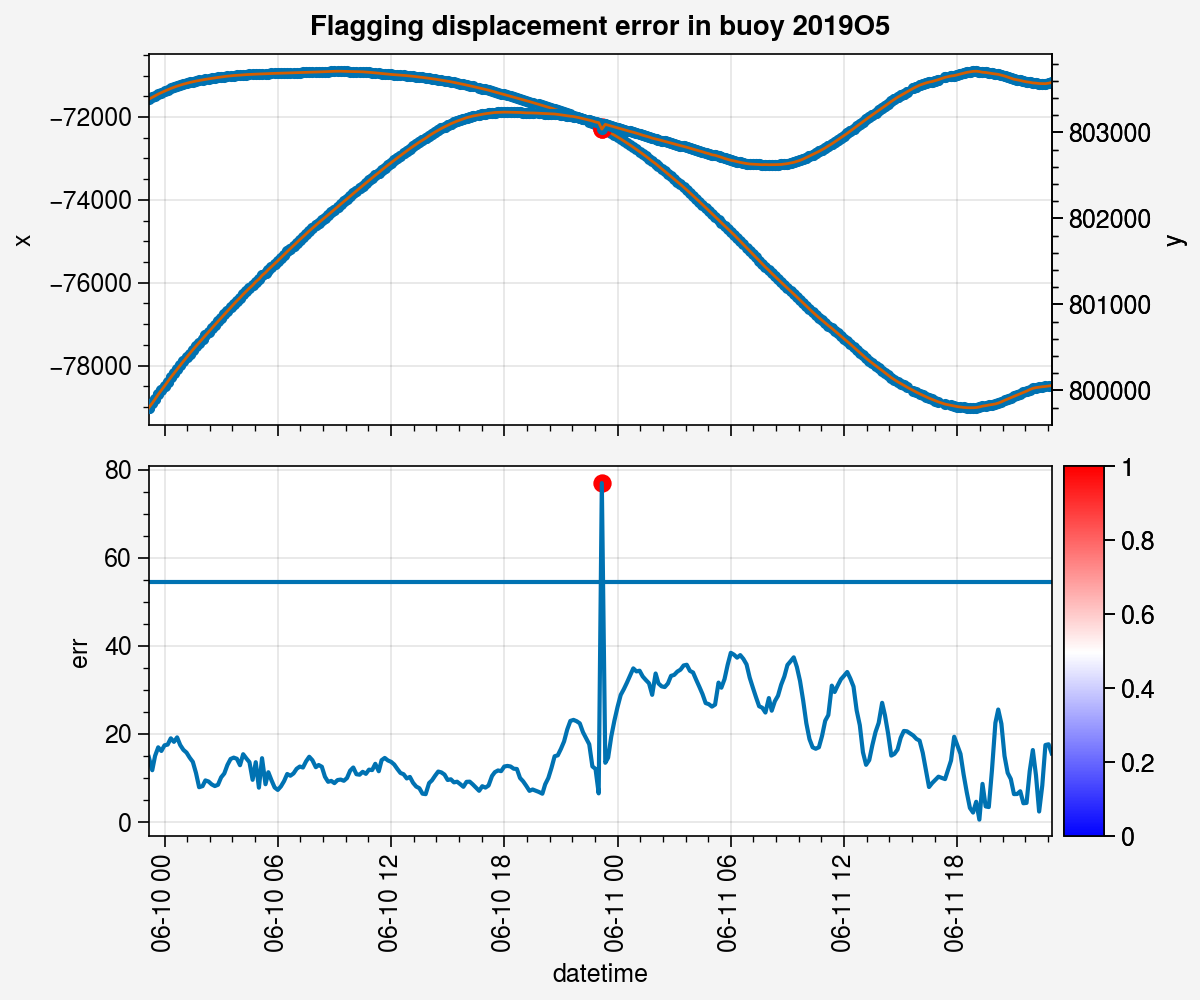

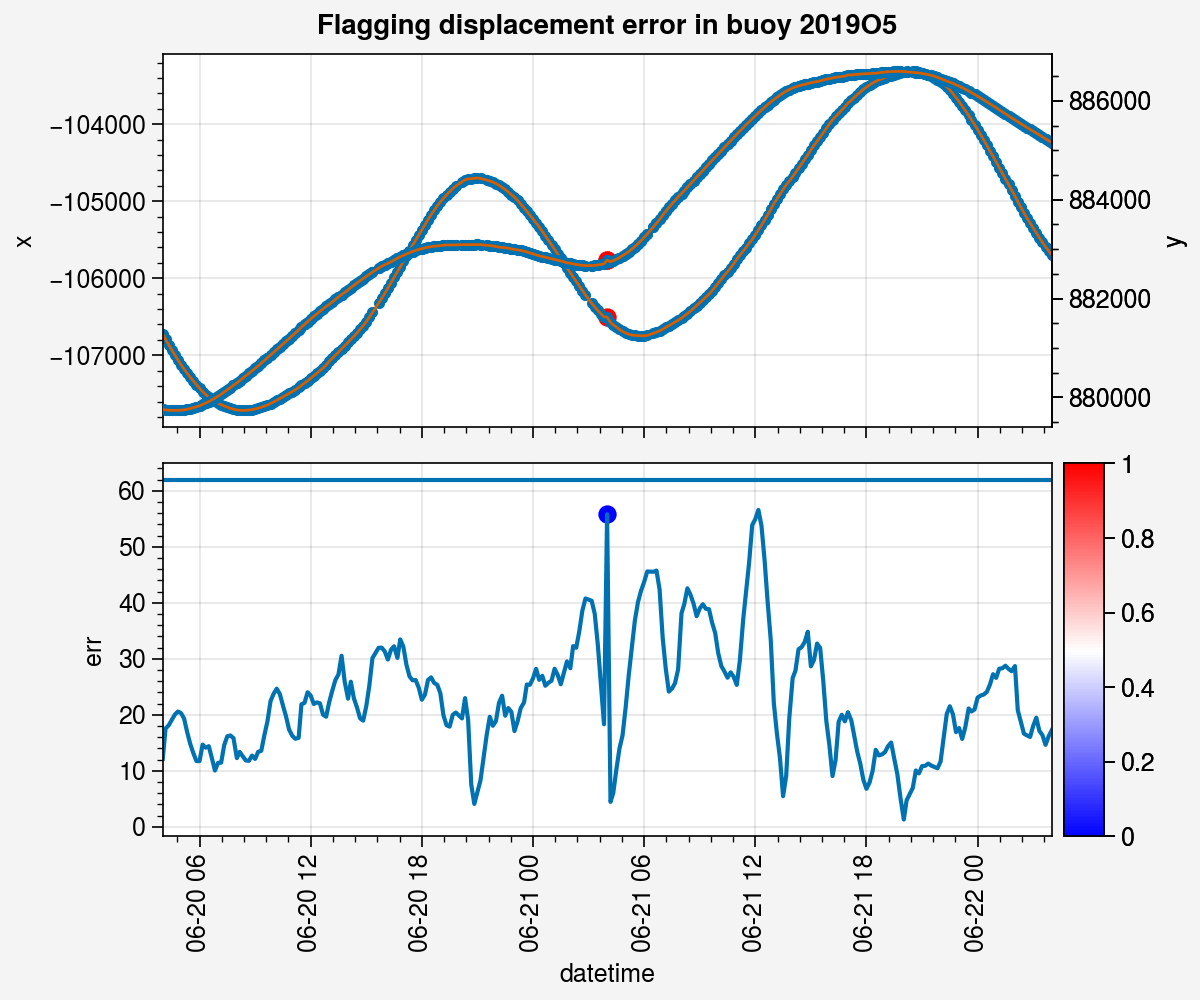

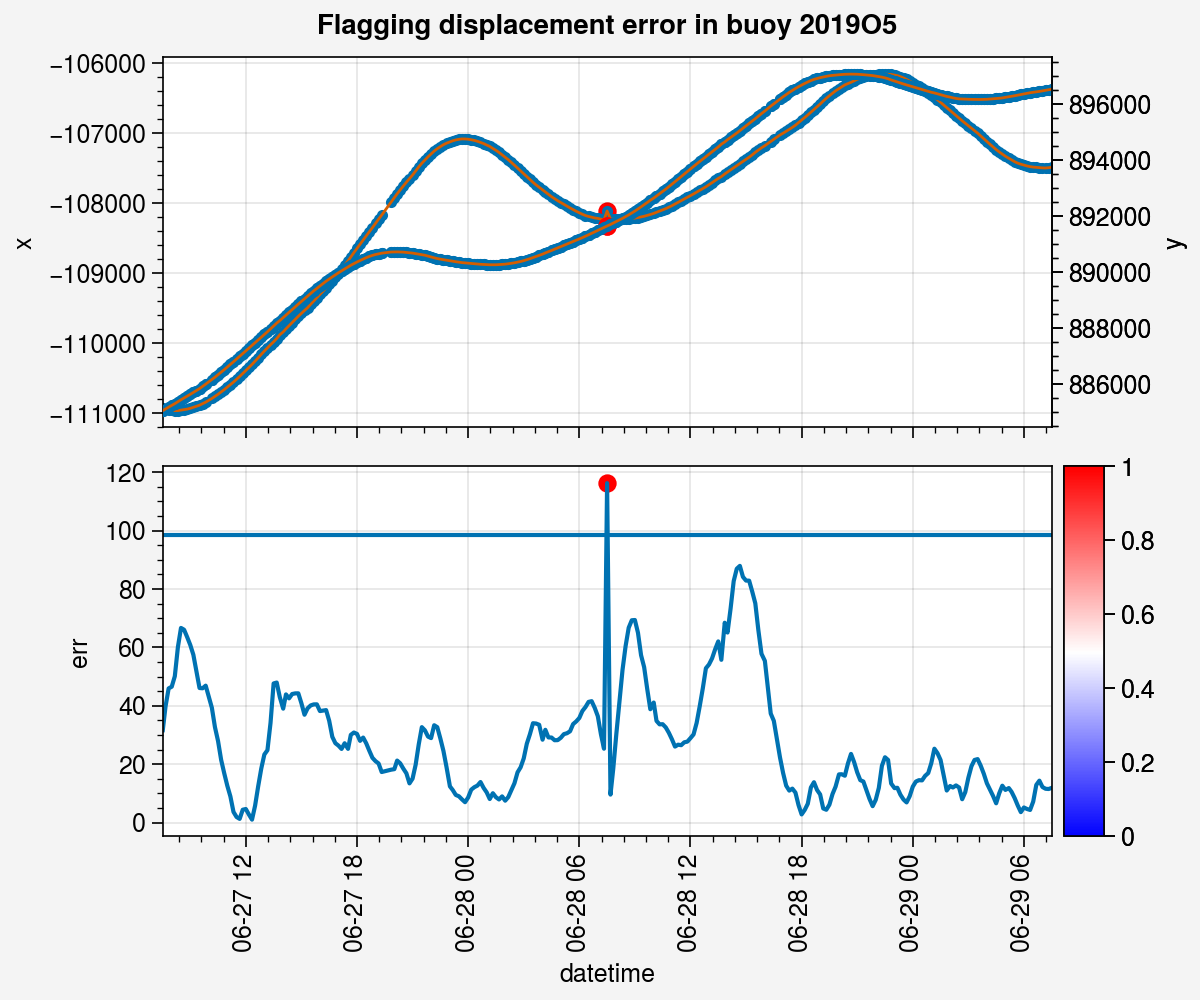

In [565]:
fit_window = '48H'
sigma=6

margin = pd.to_timedelta(fit_window)
smargin = pd.to_timedelta('24H')
for date in bad_data[buoys[buoy_idx]]:
    date = pd.to_datetime(date)
    timeslice = slice(date - margin, date + margin)
    xvar = 'x'
    yvar = 'y'
    test_fit = test_point(date, data, xvar, yvar, df=51, fit_window='48H', sigma=6)
    
    
    timeslice = slice(date - smargin, date + smargin)

    fig, axs = pplt.subplots(width=6, height=5, nrows=2, sharey=False)
    ax = axs[0]
    ax.plot(data.loc[timeslice, xvar], marker='.', lw=0)
    ax.plot(test_fit.loc[timeslice, xvar], lw=1)
    ax.scatter(date, data.loc[date, xvar], marker='o', color='r')

    ax = ax.twinx()
    ax.plot(data.loc[timeslice, yvar], marker='.', lw=0)
    ax.plot(test_fit.loc[timeslice, yvar], lw=1)
    ax.scatter(date, data.loc[date, yvar], marker='o', color='r')

    ax = axs[1]
    ax.plot(test_fit.loc[timeslice, 'err'])
    ax.axhline(6*test_fit['err'].drop(date).std())
    ax.scatter(date, test_fit.loc[date, 'err'], c=test_fit.loc[date, 'flag'], marker='o',
               cmap='bwr', vmin=0, vmax=1, colorbar='r')
    ax.format(suptitle='Flagging displacement error in buoy ' + buoys[buoy_idx])

2019R9
True


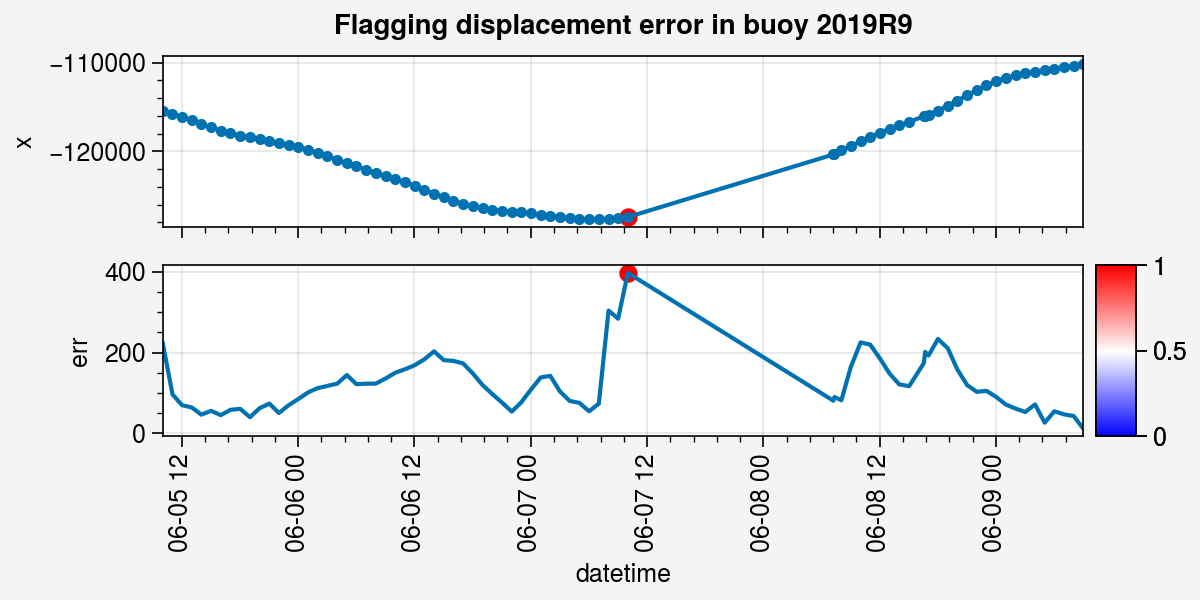

In [488]:
# Known bad data points for buoy 2019R9 (buoy_idx=0)
buoy_idx = 0
print(buoys[buoy_idx])
data = buoy_data[buoys[buoy_idx]]
date = pd.to_datetime(bad_data[buoys[buoy_idx]][0])

date = pd.to_datetime('2020-06-07 10:01:20')

fit_window = '48H'
sigma=6

margin = pd.to_timedelta(fit_window)
timeslice = slice(date - margin, date + margin)

test_fit = test_point(date, data, 'x', 'y', df=25, fit_window='48H', sigma=6)
print(np.any(test_fit.flag))

fig, axs = pplt.subplots(width=6, height=3, nrows=2, sharey=False)
ax = axs[0]
ax.plot(data.loc[timeslice, 'x'], marker='.')
ax.scatter(date, data.loc[date, 'x'], marker='o', color='r')

ax = axs[1]
ax.plot(test_fit['err'])
ax.scatter(date, test_fit.loc[date, 'err'], c=test_fit.loc[date, 'flag'], marker='o',
           cmap='bwr', vmin=0, vmax=1, colorbar='r')
ax.format(suptitle='Flagging displacement error in buoy ' + buoys[buoy_idx])

In [457]:
test_fit.index.min(), test_fit.index.max()

(Timestamp('2019-12-19 00:01:48'), Timestamp('2019-12-22 23:01:17'))

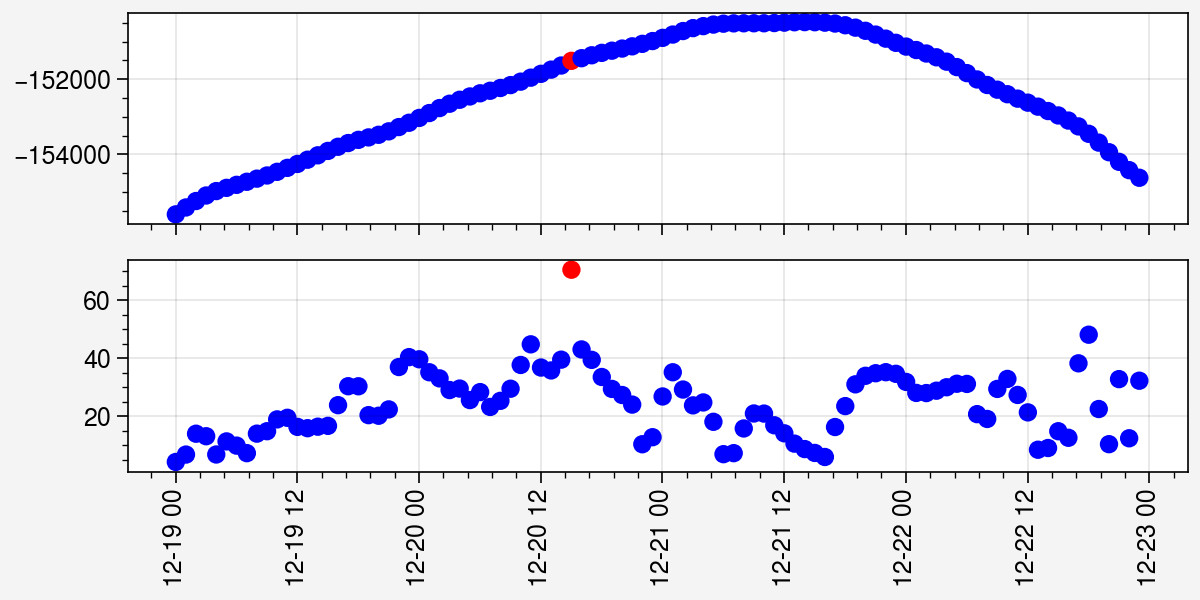

In [456]:
fig, ax = pplt.subplots(width=6, height=3, nrows=2)
ax[0].scatter(test_fit.index.values, test_fit.y.values, c=test_fit.flag.astype(int), cmap='bwr')
#ax[0].format(ylim=(test_fit.loc[test_fit.flag==1, 'y'].values - 500, test_fit.loc[test_fit.flag==1, 'y'].values+ 500))
ax[1].scatter(test_fit.index.values, test_fit.err.values, c=test_fit.flag.astype(int), cmap='bwr')

In [293]:
count = 0
itermax = 5
min_items = 20

fit_window='48H'
test_window='24H'
xvar = 'x'
yvar = 'y'
data['flag'] = False
test_margin = pd.to_timedelta(test_window)
testslice = slice(date - test_margin, date + test_margin)
margin = pd.to_timedelta(fit_window)
timeslice = slice(date - margin, date + margin)
# select indices in timeslice that haven't been flagged yet
keep_idx = data.where(~data['flag']).loc[timeslice, 'x'].dropna().index
outlier_idx = []
any_outliers = True
# while any_outliers & (count < itermax):
#     if len(data.loc[keep_idx] > min_items):
#         xy_hat = fit_splines(data.loc[keep_idx])
#         outliers = xy_hat.err > 6*xy_hat.err.std()
#         data.loc[xy_hat.index[outliers], 'flag'] = True
#         any_outliers = outliers.sum() > 0
#         keep_idx = xy_hat.loc[~outliers].index
#     else:
#         any_outliers = False

Outlier detection procedure

After an initial pass to remove duplicated dates, duplicated coordinates, and out-of-range latitudes and longitudes, we make a more detailed check for offset data points and non-physical drift speeds.

Offset data points (Reference figure) occur in many data tracks, where a single point is a few hundred meters away from the true position of the buoy. However, simple comparison to neighboring points can lead to falsely identifying the points of reversals in drift track direction as being anomalous. 

Buoys have different reporting rates and position uncertainty, and both reporting rate and uncertainty vary with weather, drift speed, buoy status (whether covered in snow or ice or not), and sensor age. This makes identifying anomalous positions challenging.

I envision that the fitting method for identifying anomalous positions is going to require a step to figure out the right degrees of freedom to use in the model, as well as the right window for fitting. These will likely vary through the year and will vary with the different resolutions.


instantaneous velocity greater than 10 m/s

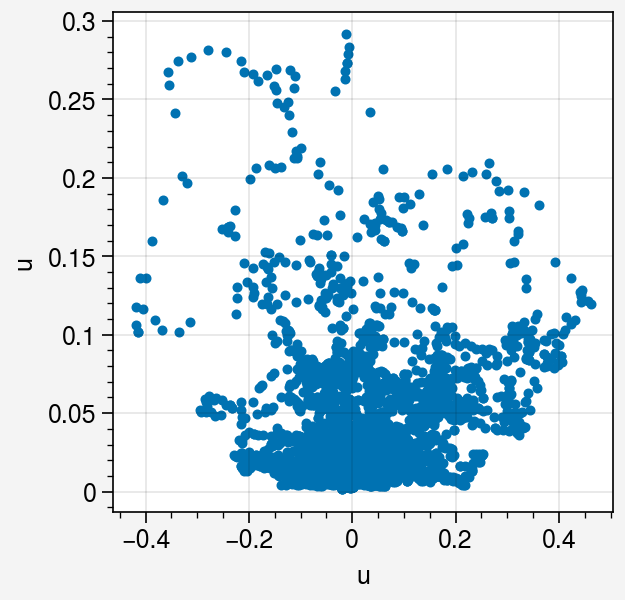

In [556]:
umean = data.u.rolling('1D', center=True).mean()
ustd = (data.u - umean).rolling('1D', center=True).std()
fig, ax = pplt.subplots()
ax.scatter(umean, ustd, marker='.')